In [1]:
from __future__ import annotations

from torch.utils.data import random_split

from mmpfn.datasets.airbnb import AirbnbDataset

import os 
import torch 
import numpy as np 
import pandas as pd

from sklearn.metrics import accuracy_score
from mmpfn.models.mmpfn_v2 import MMPFNClassifier
from mmpfn.models.mmpfn_v2.constants import ModelInterfaceConfig
from mmpfn.models.mmpfn_v2.preprocessing import PreprocessorConfig
from mmpfn.scripts_finetune_mm.finetune_tabpfn_main import fine_tune_mmpfn

/home/wall/anaconda3/envs/mmpfn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wall/works/research/MultiModalPFN/mmpfn/models/dino_v2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/wall/works/research/MultiModalPFN/mmpfn/models/dino_v2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/wall/works/research/MultiModalPFN/mmpfn/models/dino_v2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # for debugging

In [3]:
data_path = os.path.join(os.getenv('HOME'), "works/research/MultiModalPFN/mmpfn/data/airbnb")
dataset = AirbnbDataset(data_path)
_ = dataset.get_embeddings()

/home/wall/works/research/MultiModalPFN/mmpfn/datasets/airbnb.py:29: DtypeWarning: Columns (35,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_path, FILENAME))


Load embeddings from embeddings/airbnb/airbnb.pt


Fine-tuning Steps:   5%|▌         | 5/100 [00:36<14:32,  9.19s/it, Best Val. Loss=1.37, Best Val. Score=-1.37, Training Loss=1.38, Val. Loss=1.37, Patience=46, Utilization=0, Grad Norm=4.73][2025-09-14 14:58:35,999] INFO - 
Optimizer step skipped due to NaNs/infs in grad scaling.
Fine-tuning Steps:  11%|█         | 11/100 [01:27<13:07,  8.84s/it, Best Val. Loss=1.36, Best Val. Score=-1.36, Training Loss=1.31, Val. Loss=1.36, Patience=41, Utilization=0, Grad Norm=3.85]/home/wall/works/research/MultiModalPFN/mmpfn/models/mmpfn_v2/model/transformer.py:769: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16, 8))
Fine-tuning Steps: 101it [14:52,  8.92s/it, Best Val. Loss=1.34, Best Val. Score=-1.34, Training 

accuracy_score (Finetuned): 0.4725676664228237


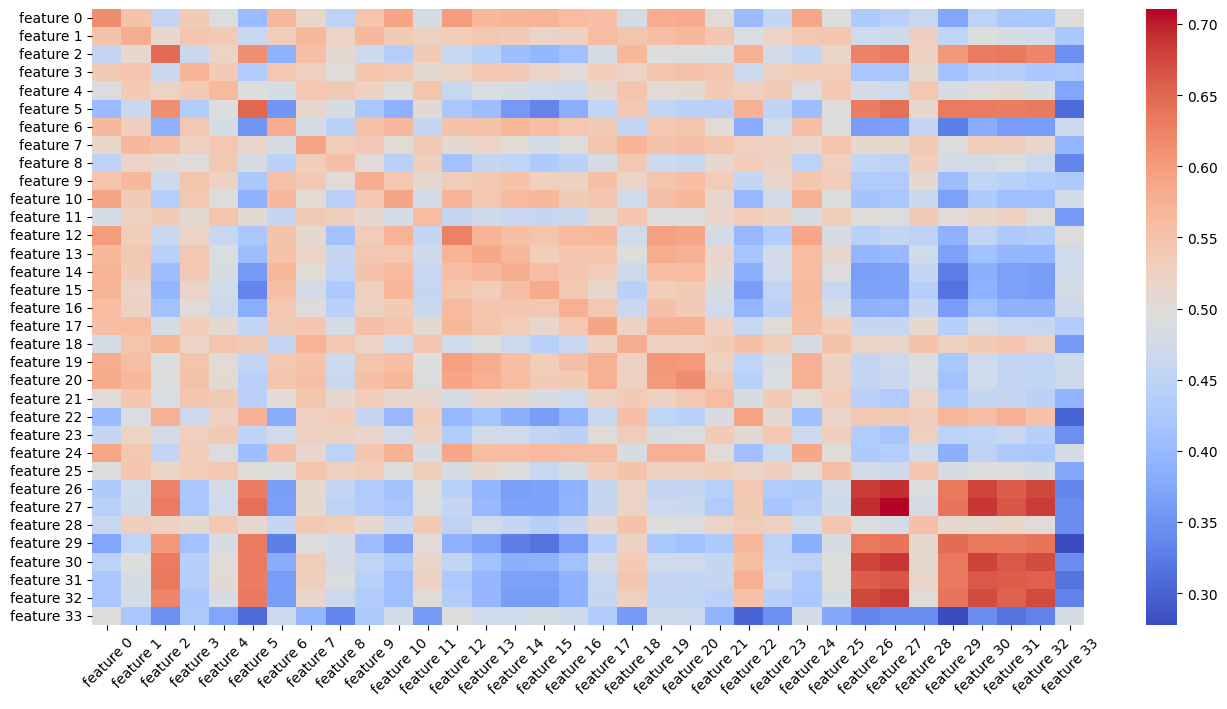

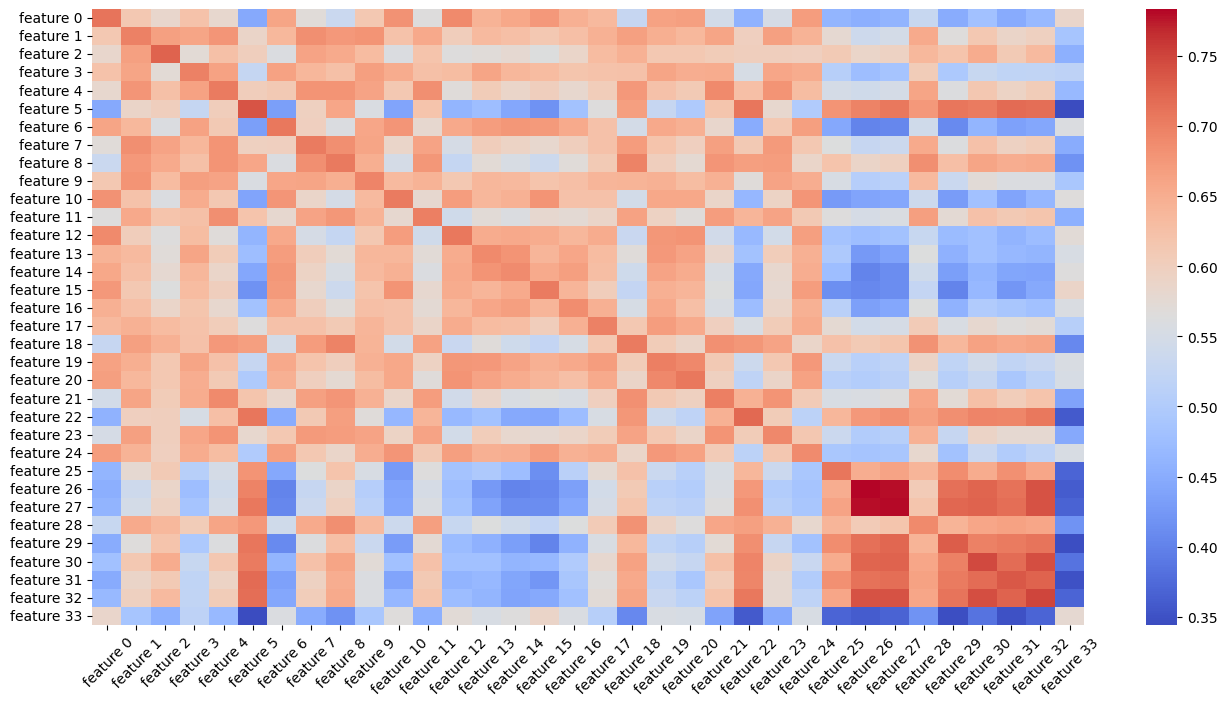

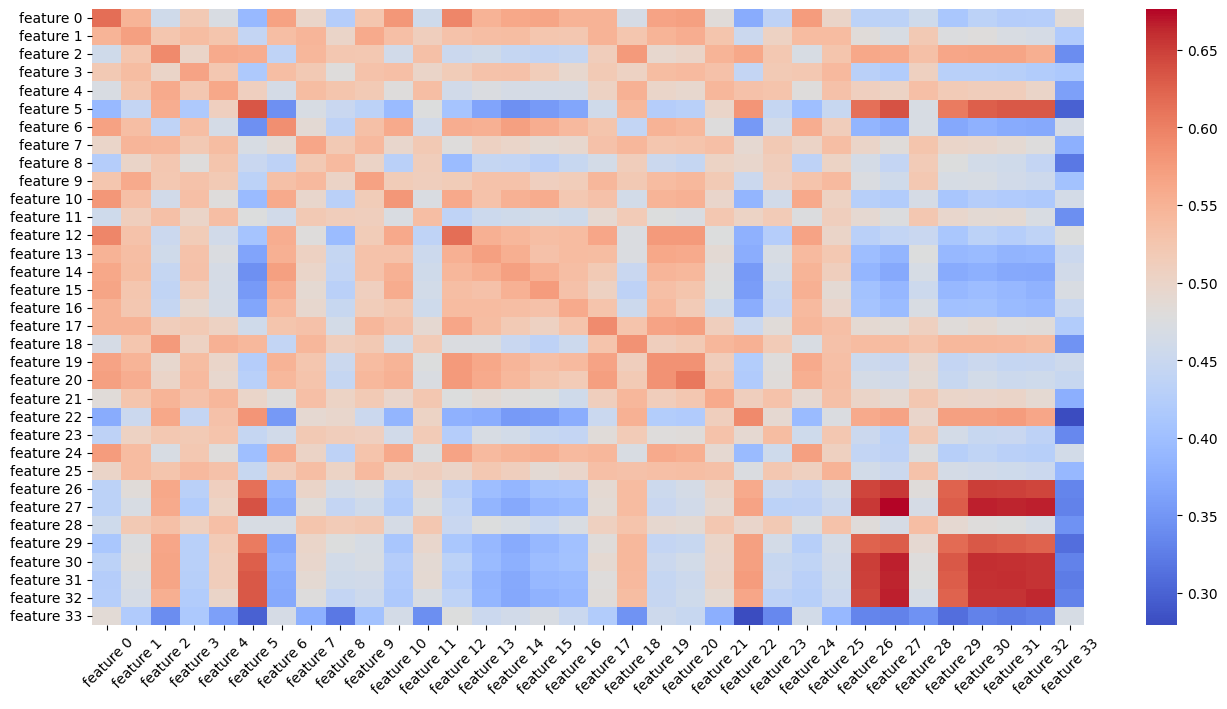

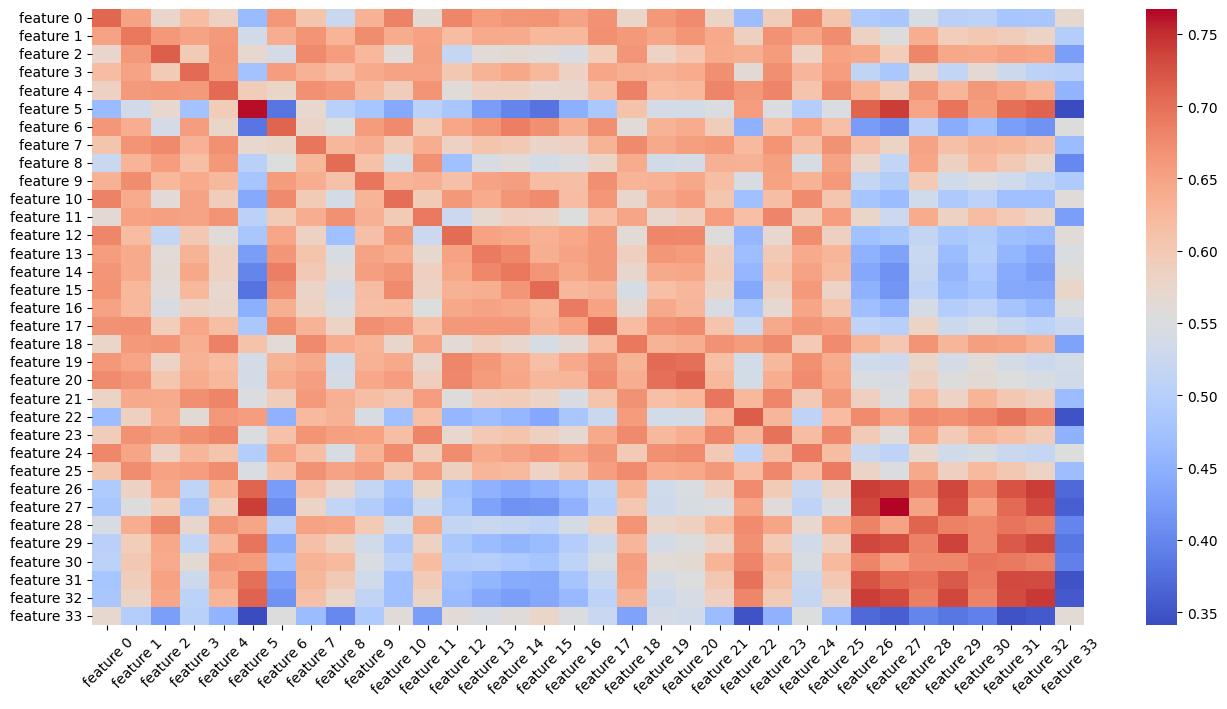

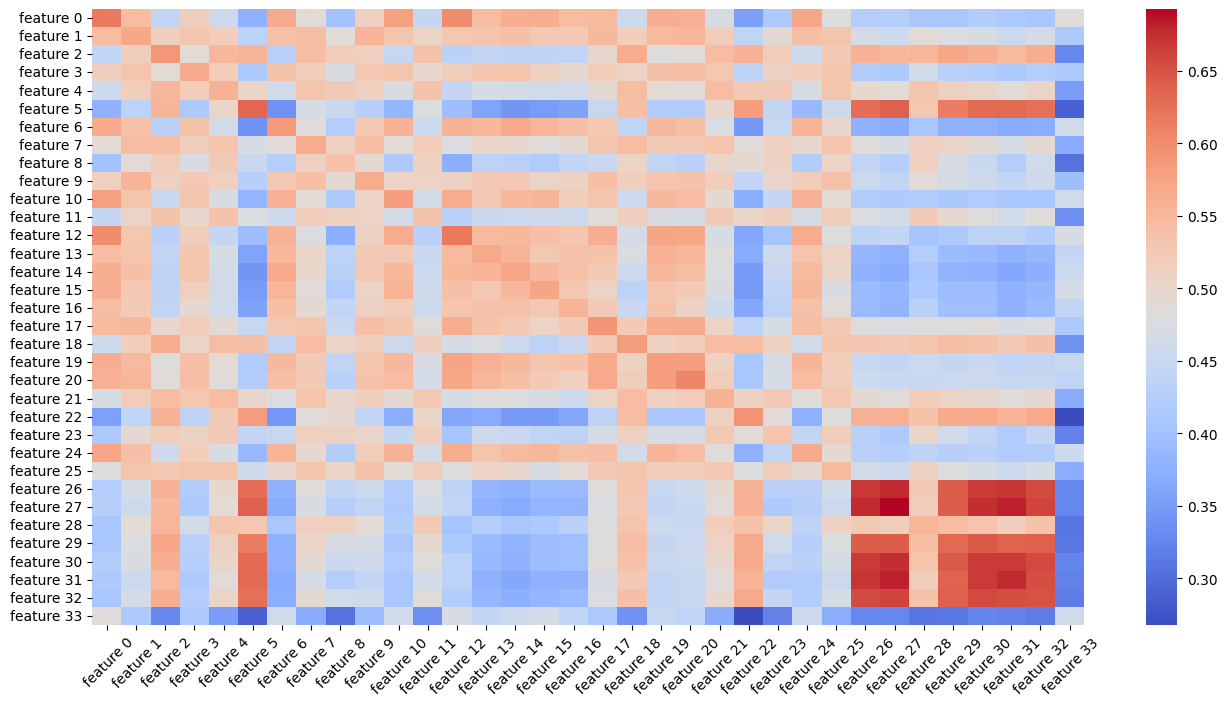

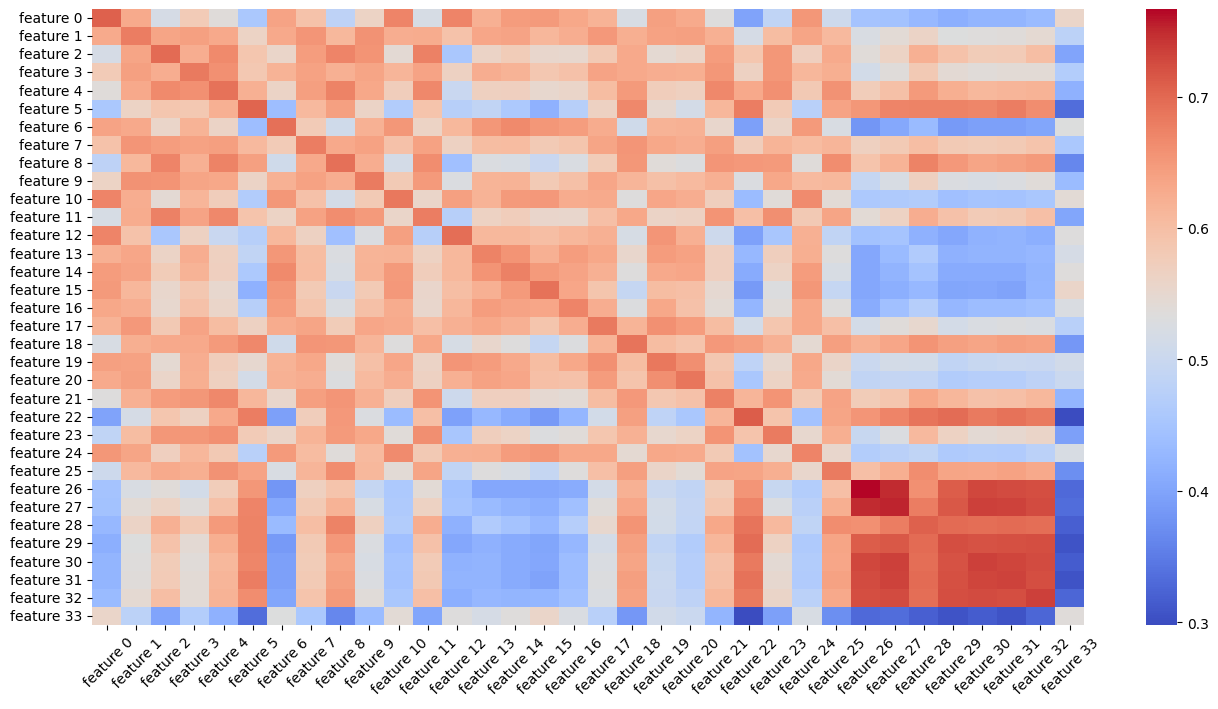

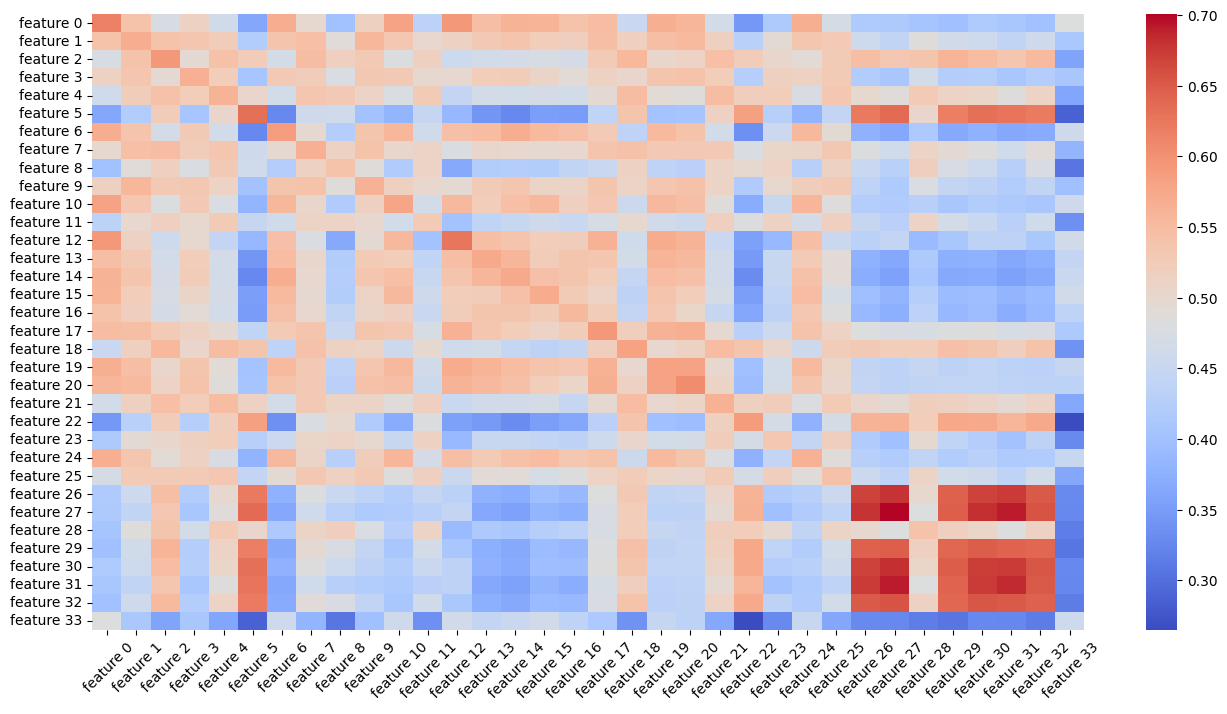

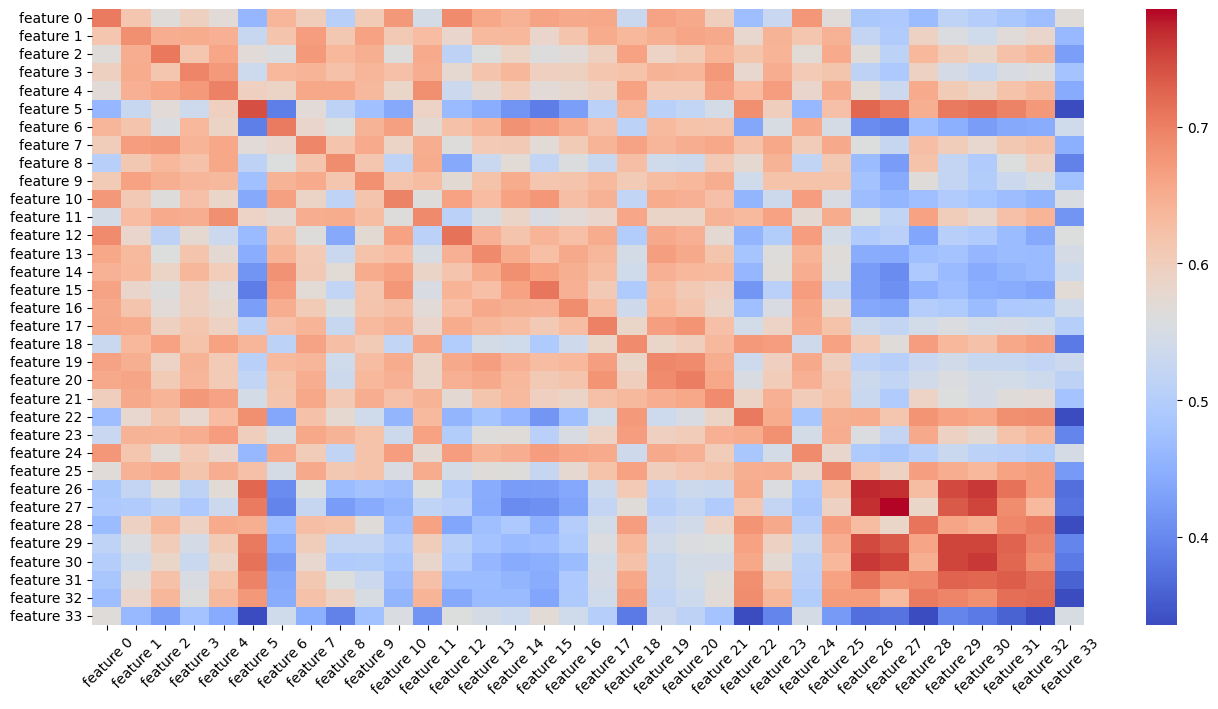

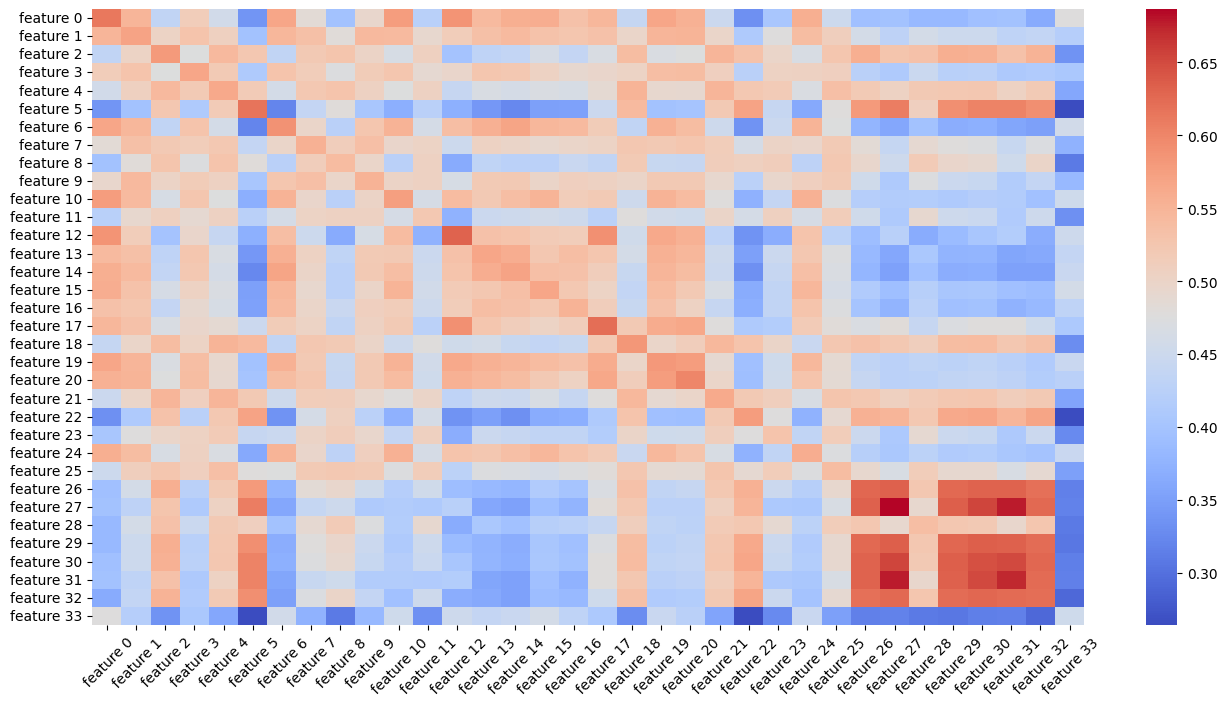

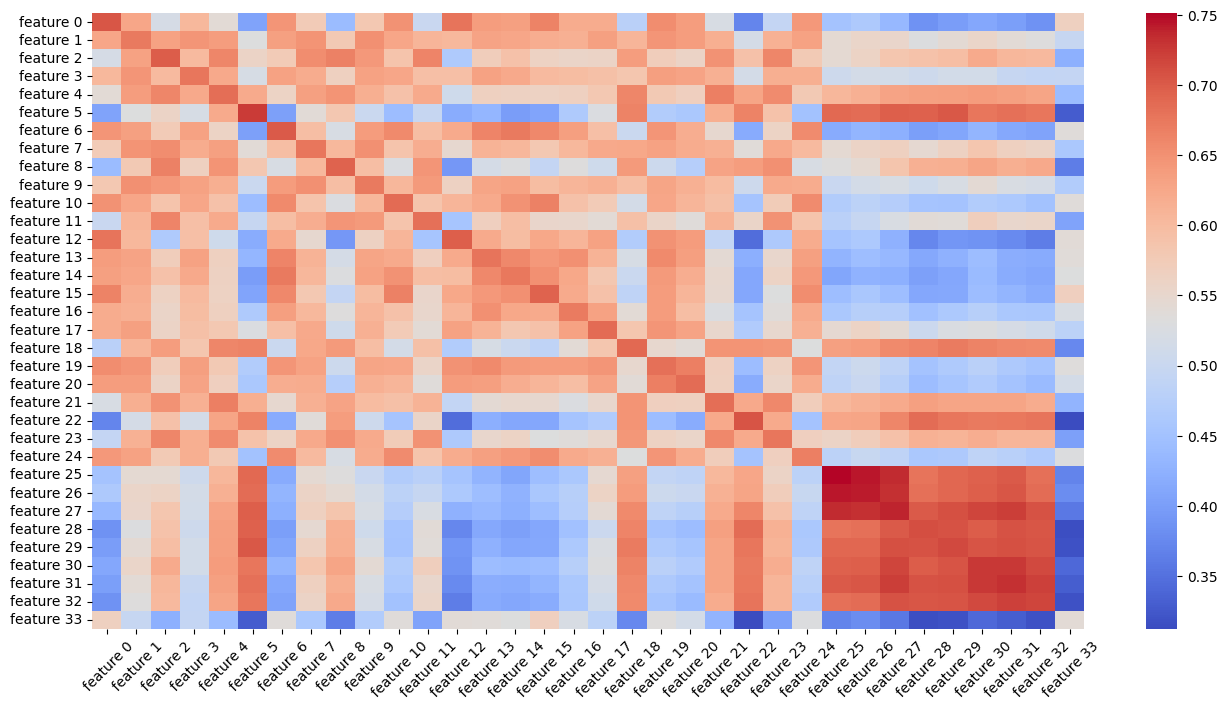

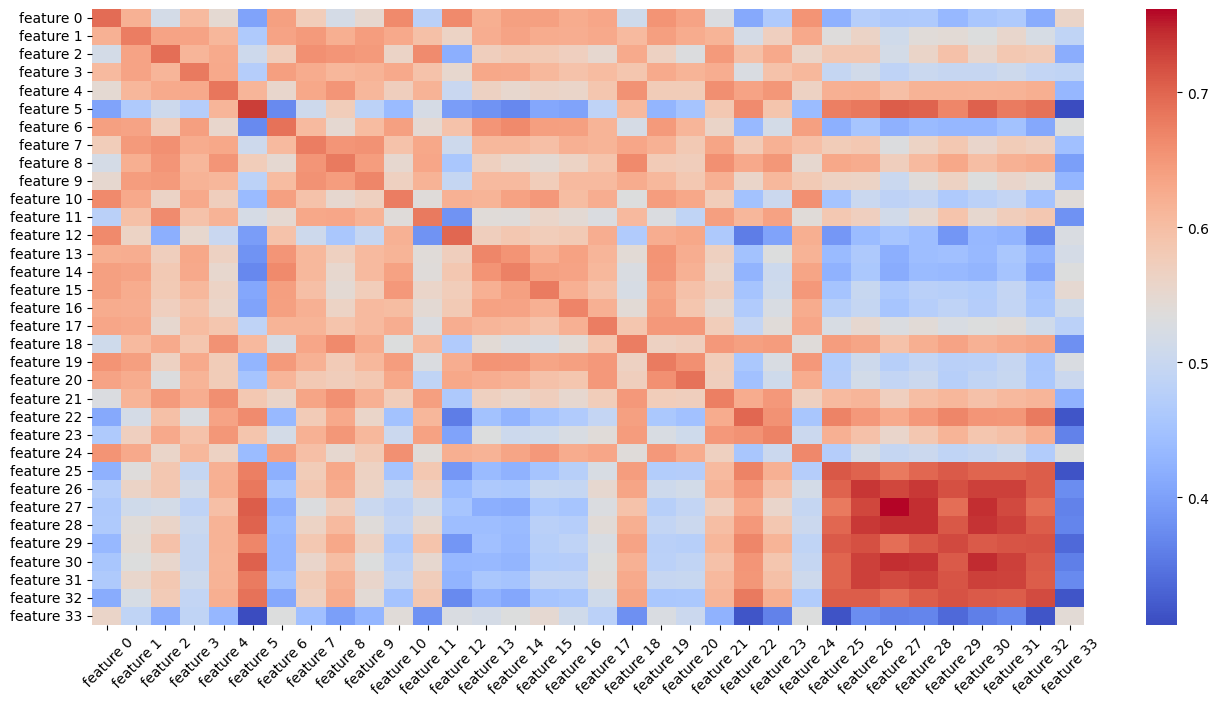

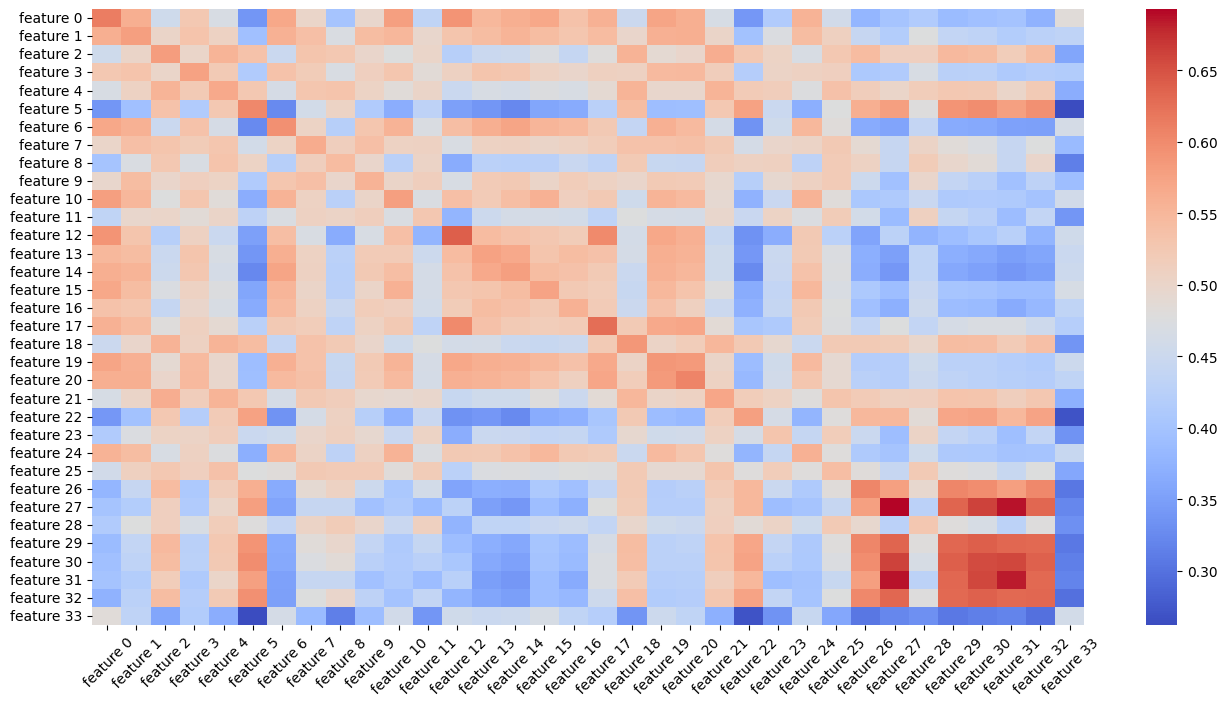

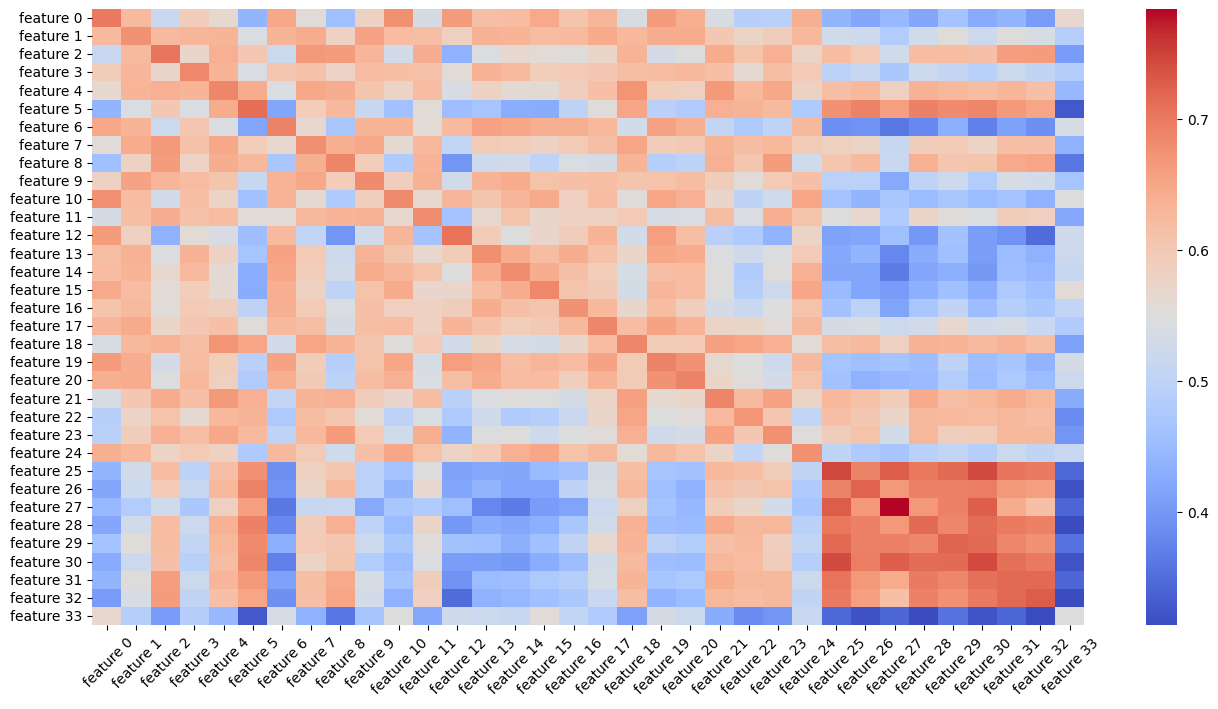

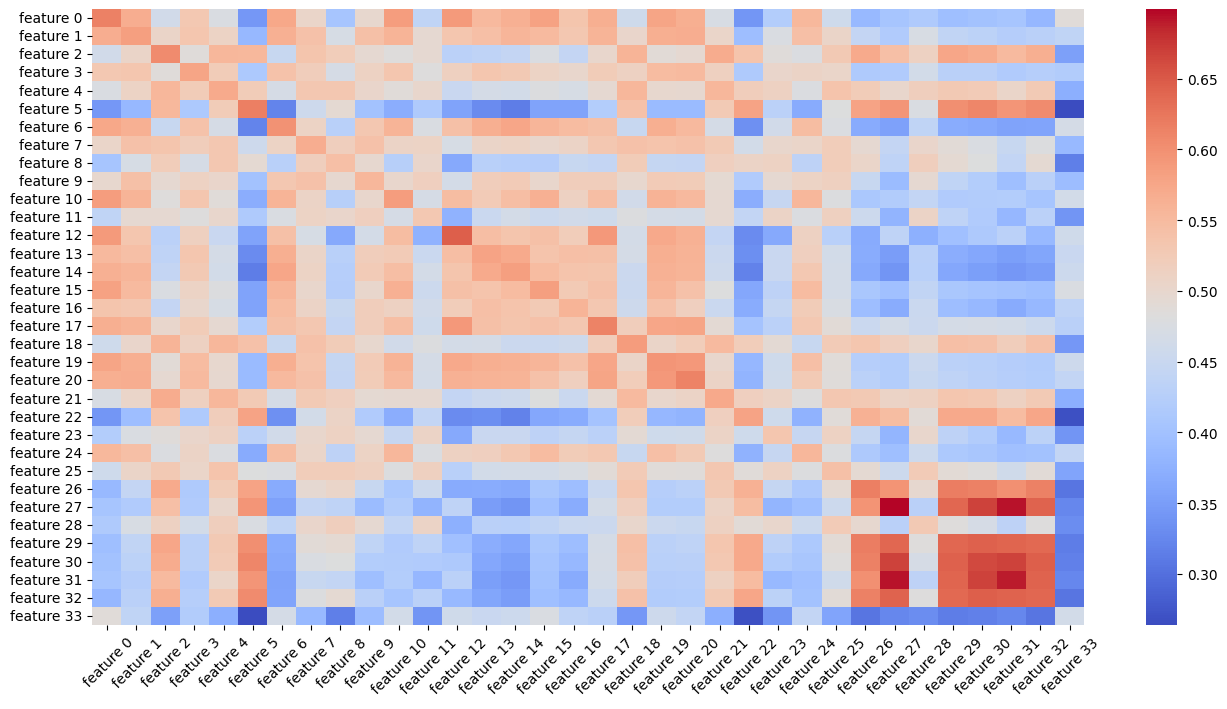

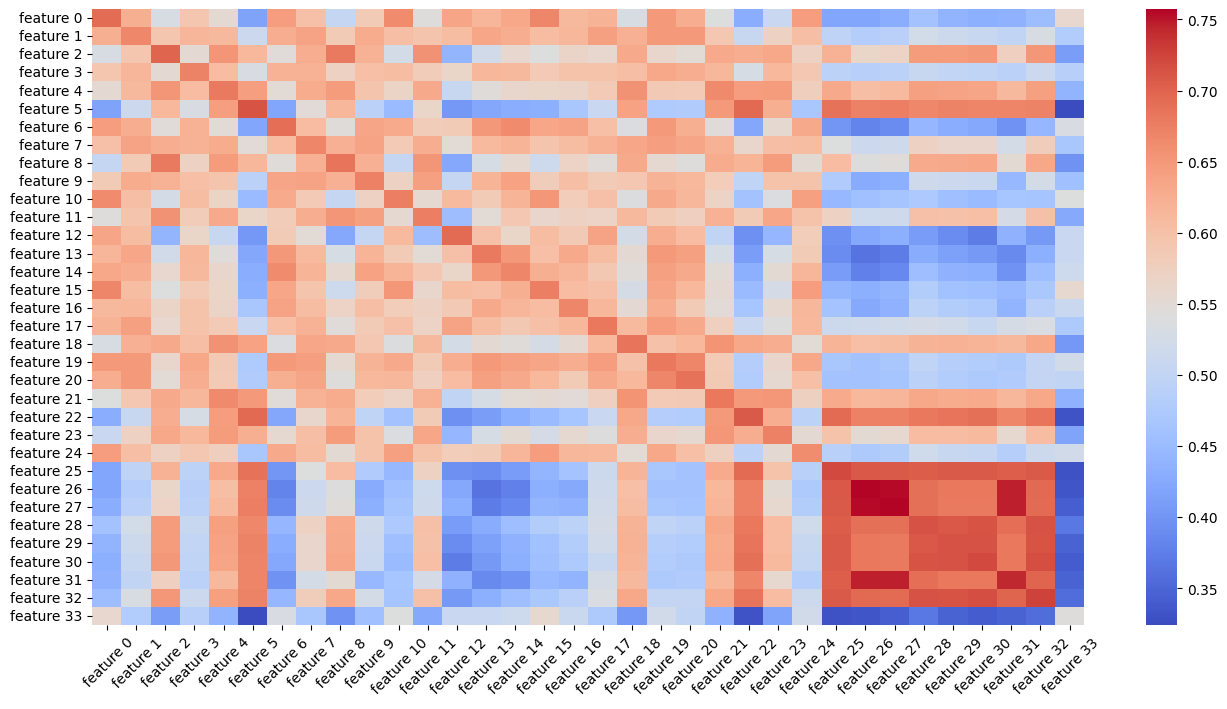

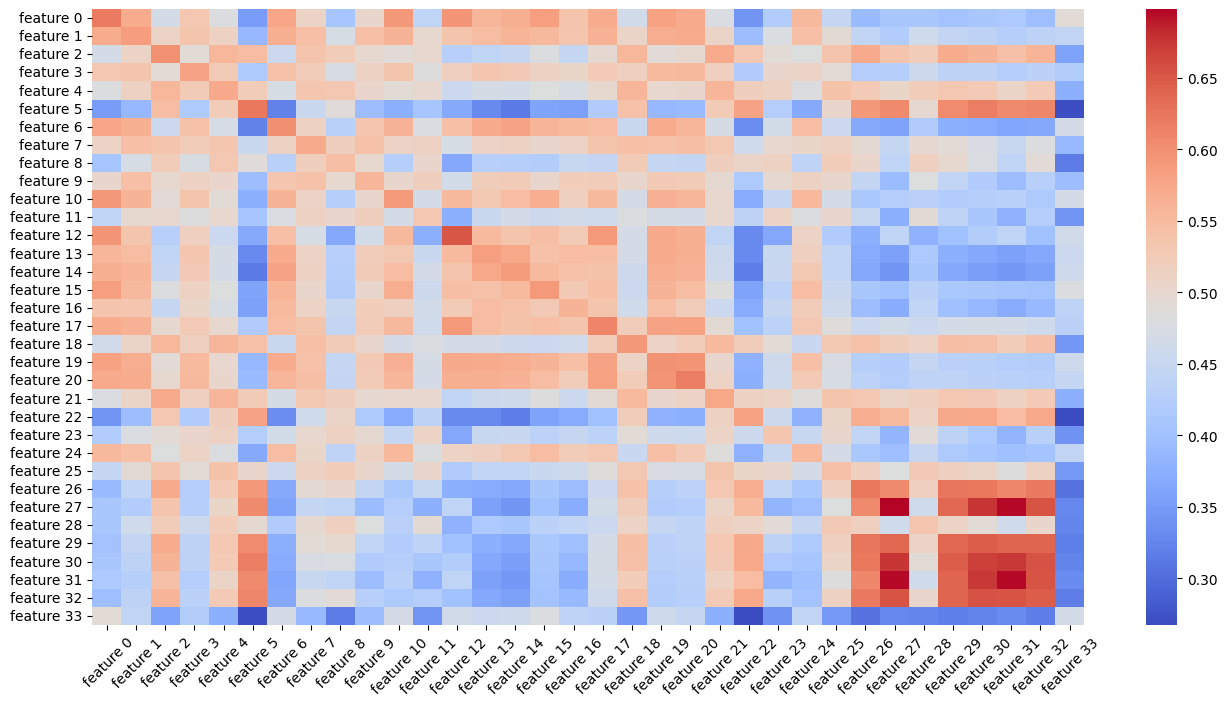

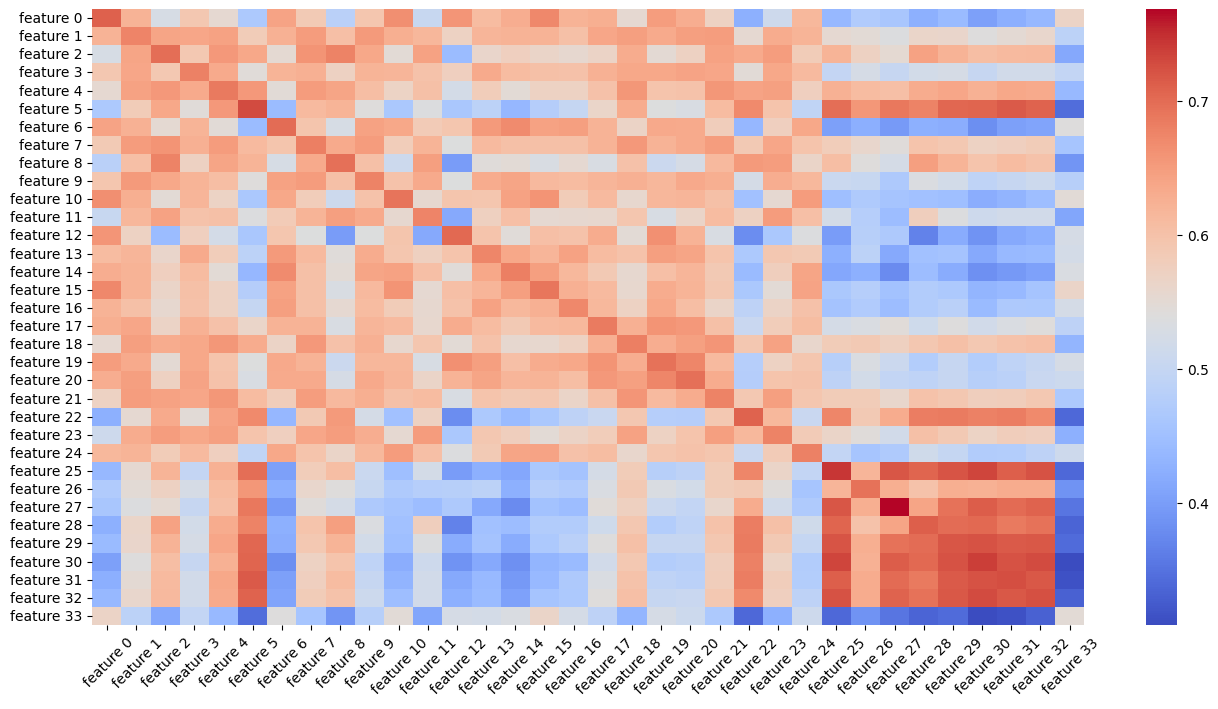

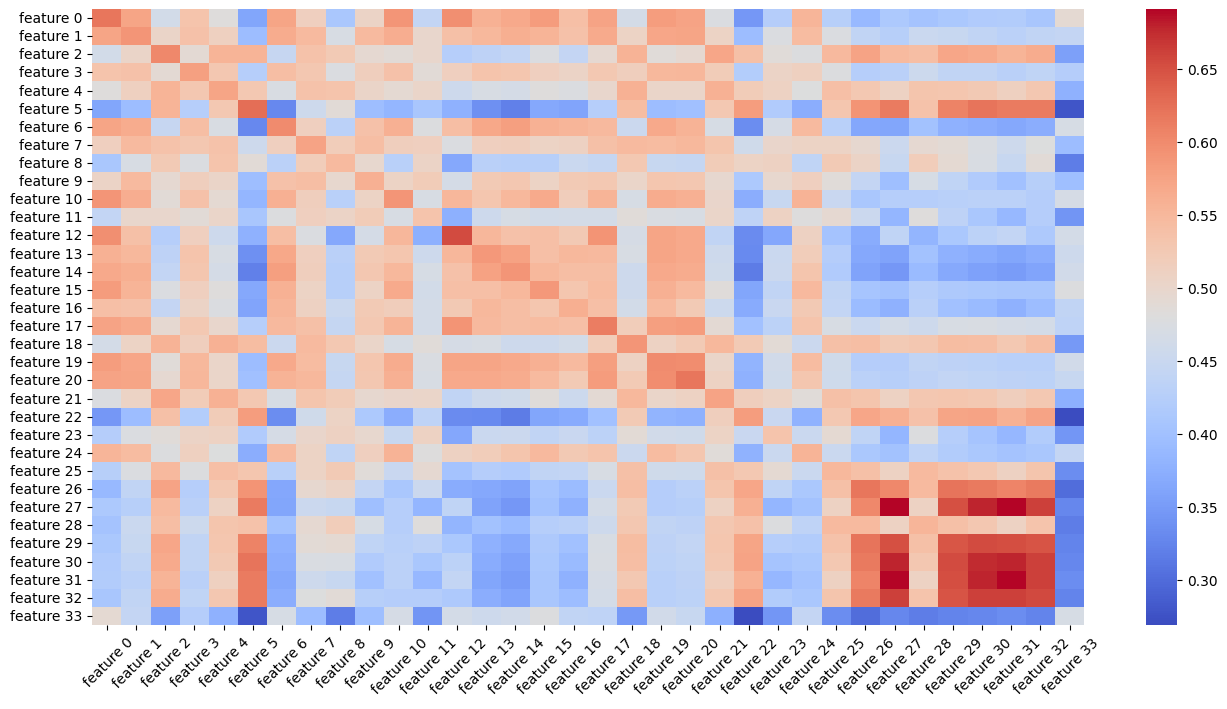

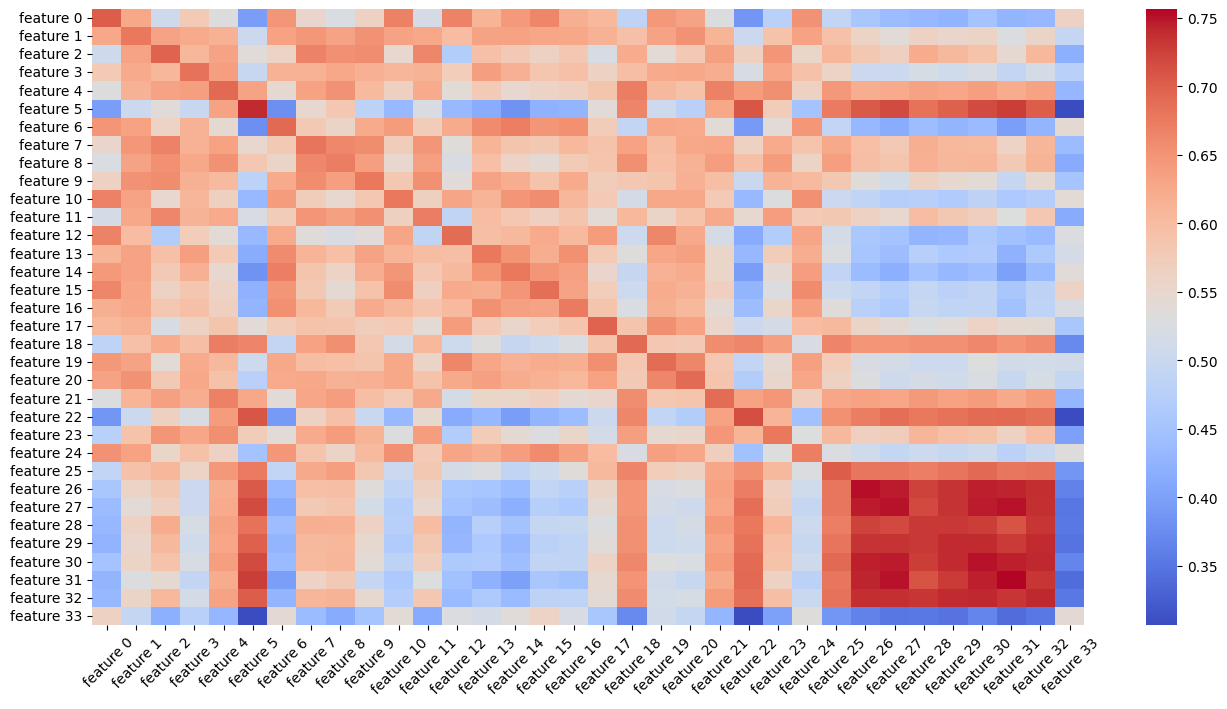

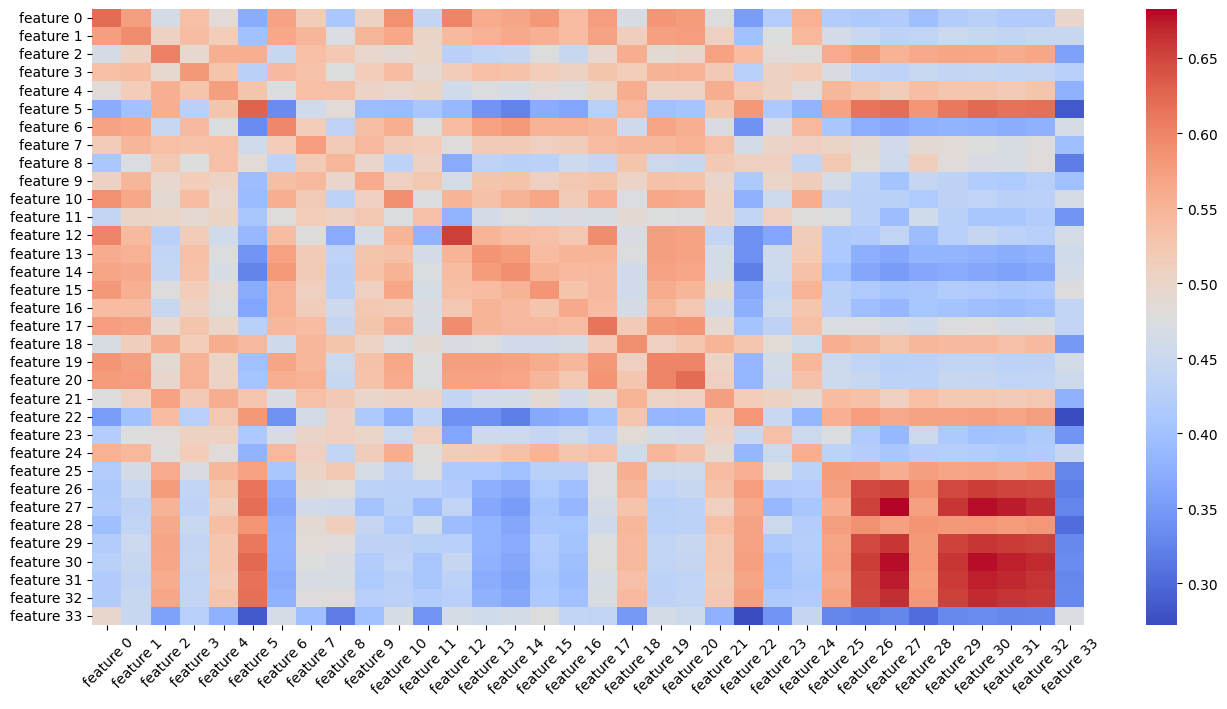

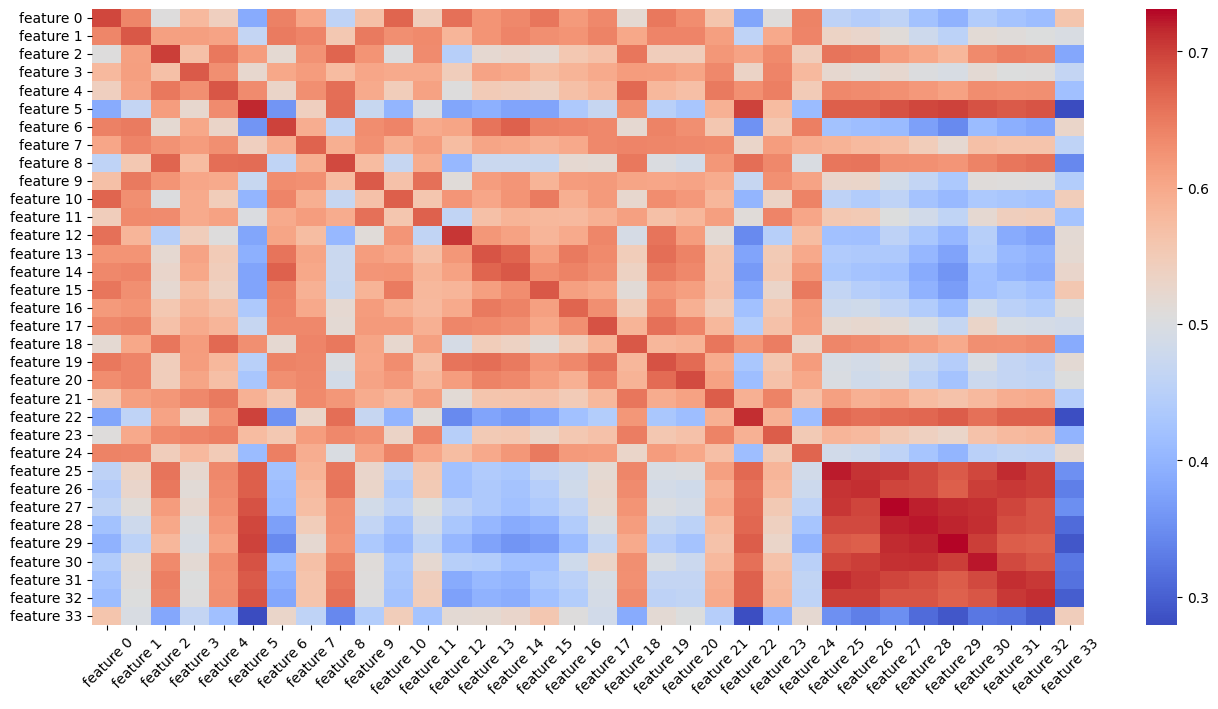

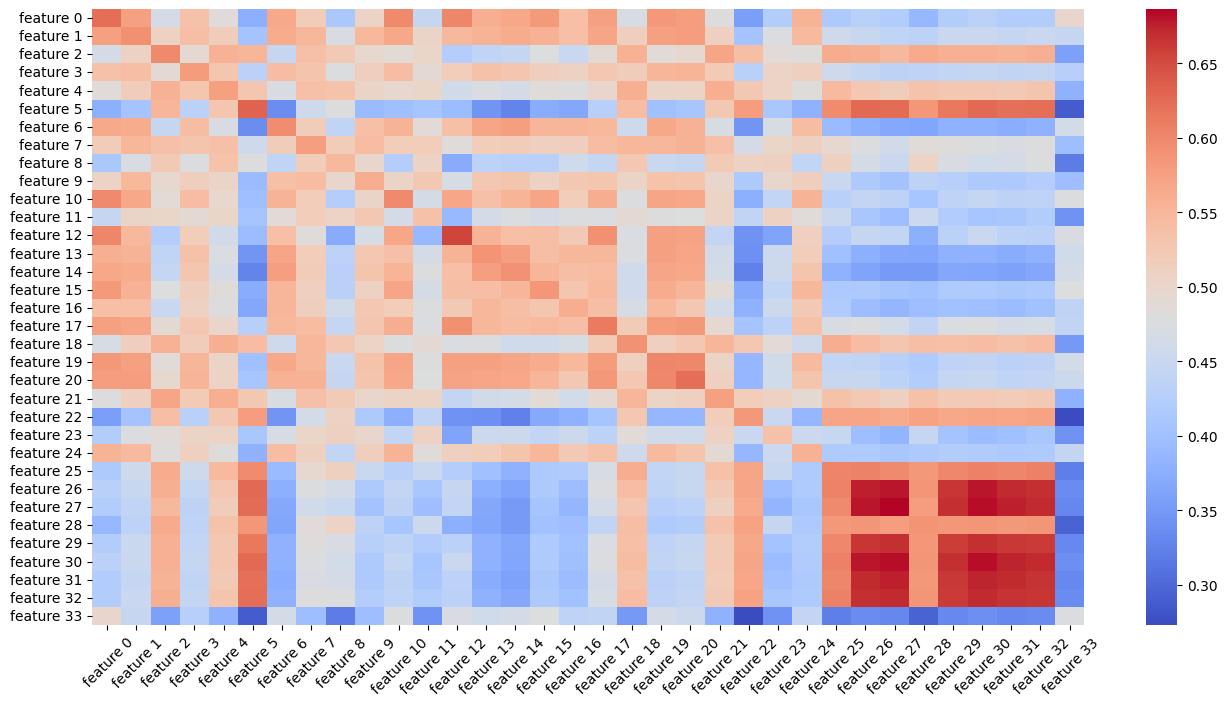

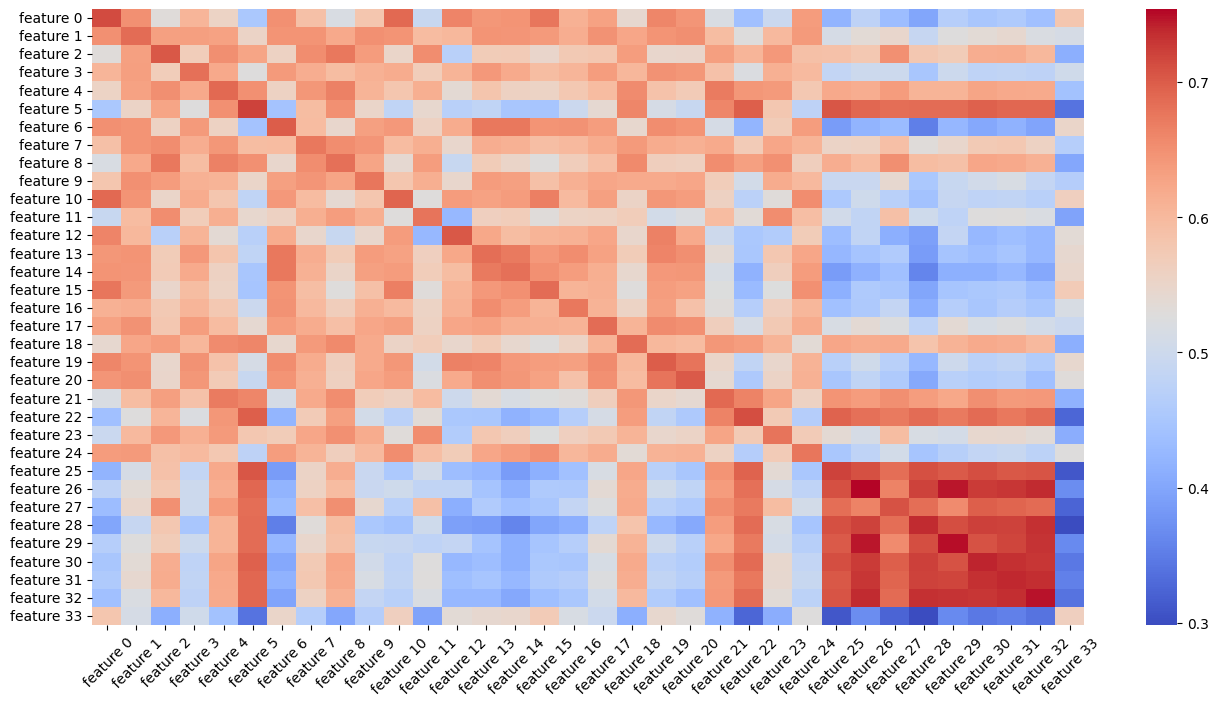

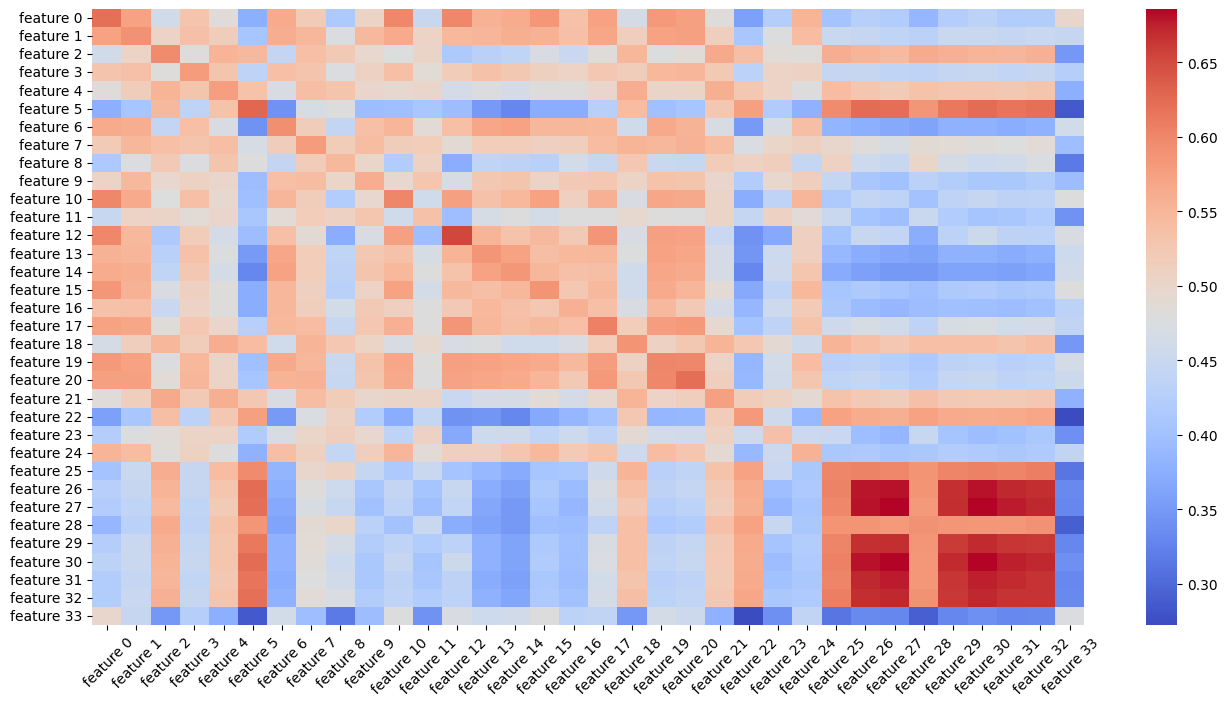

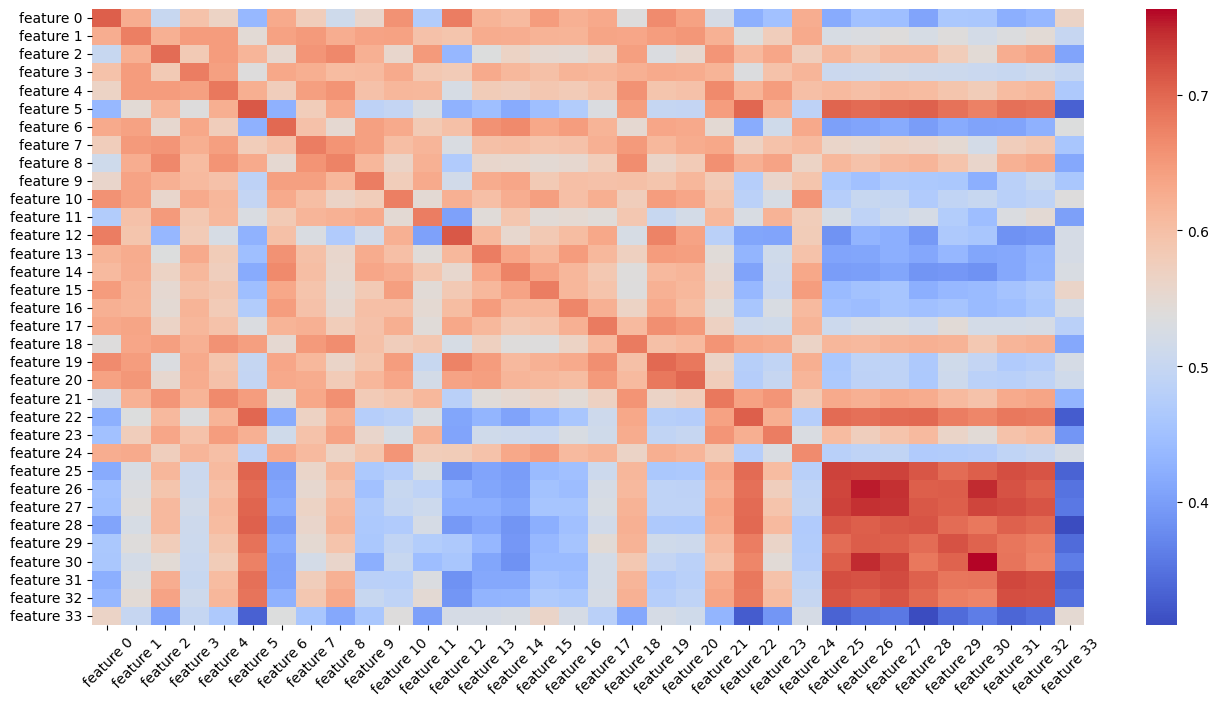

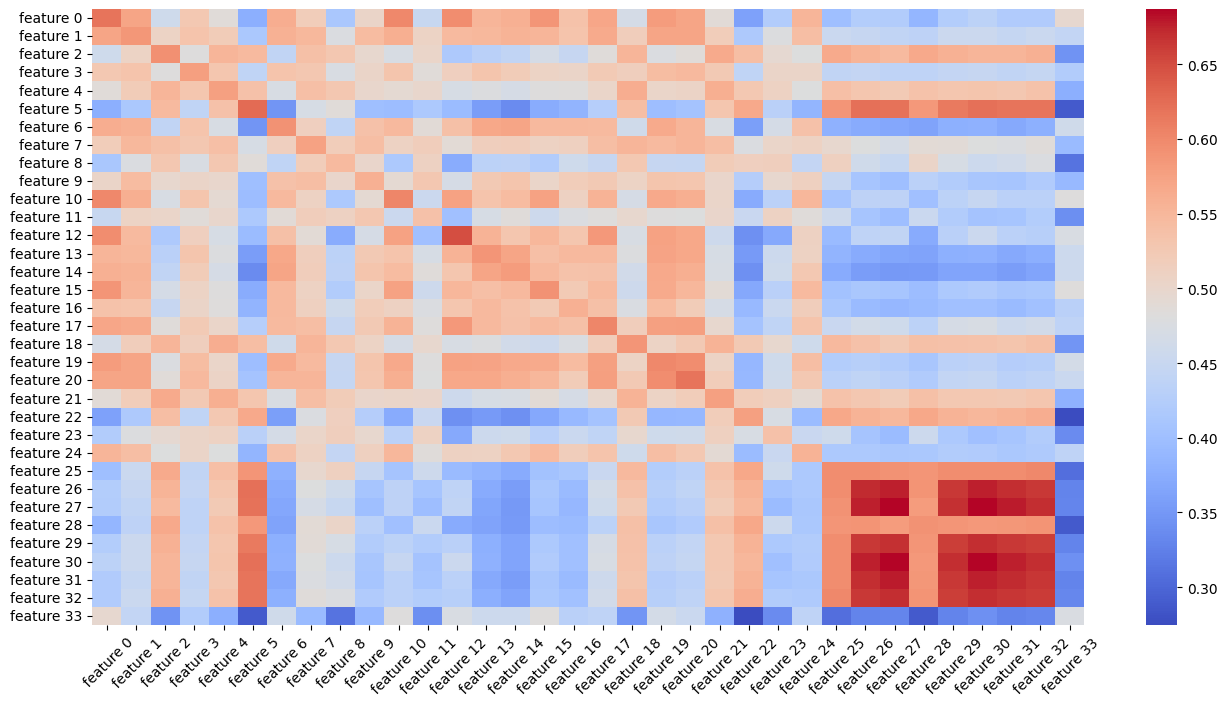

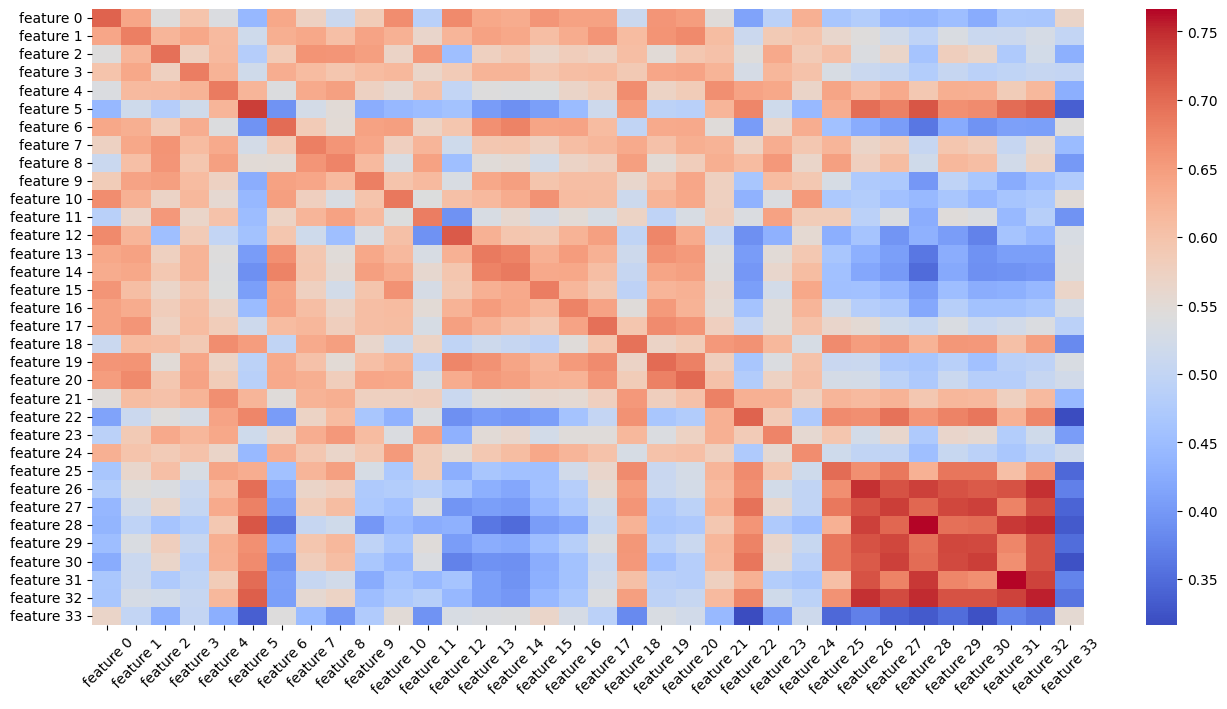

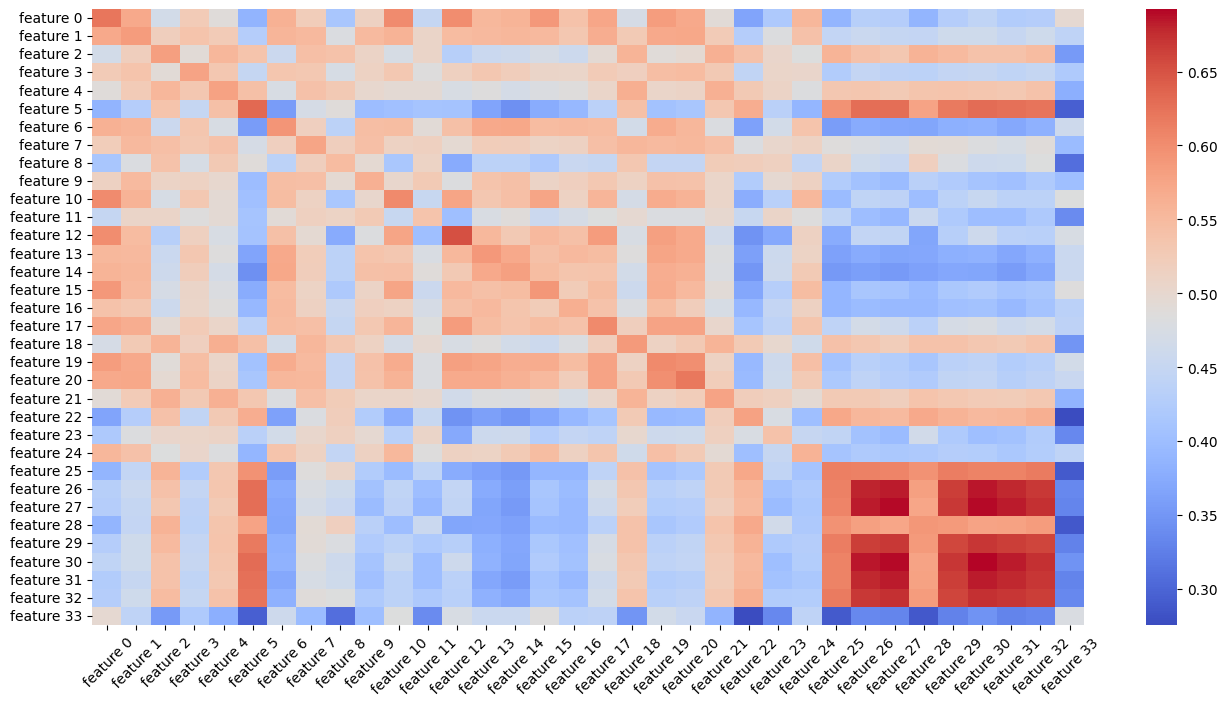

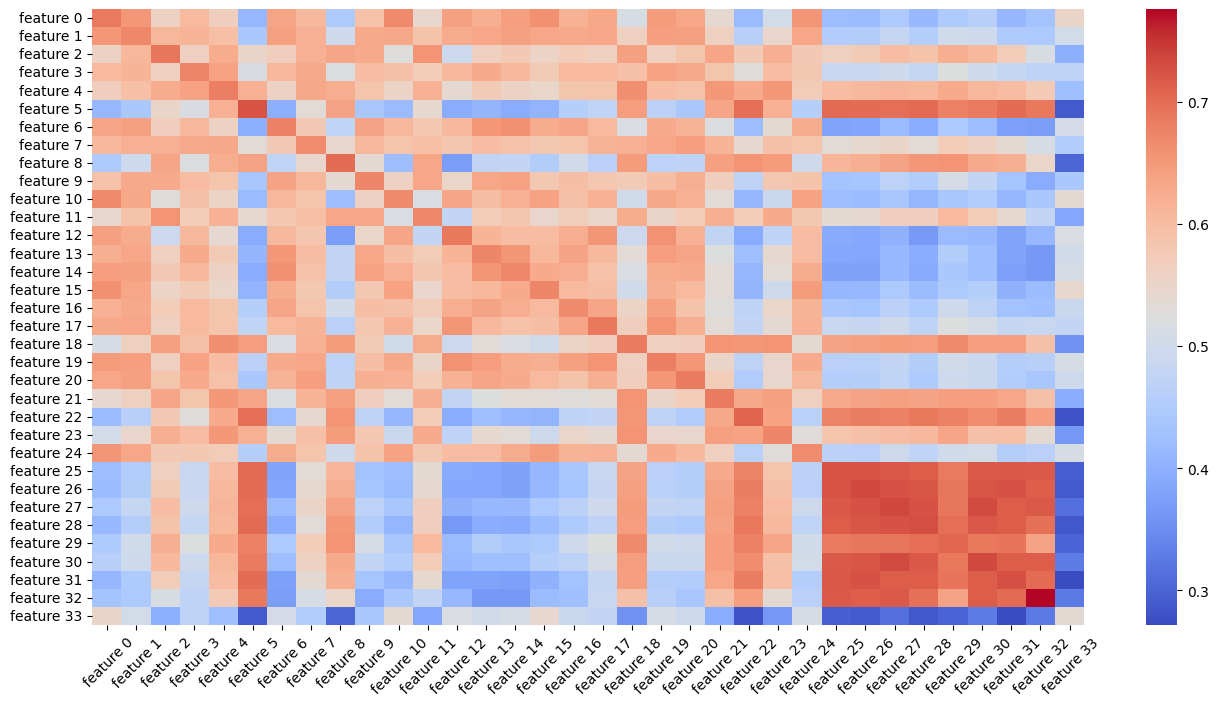

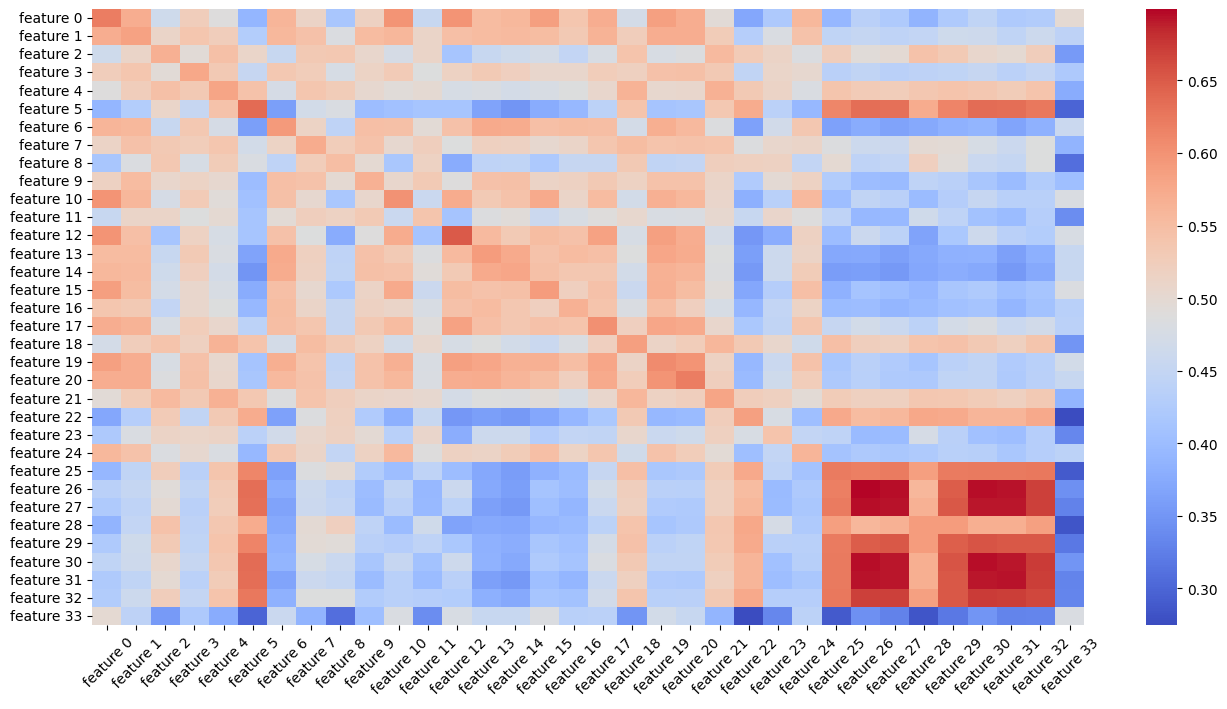

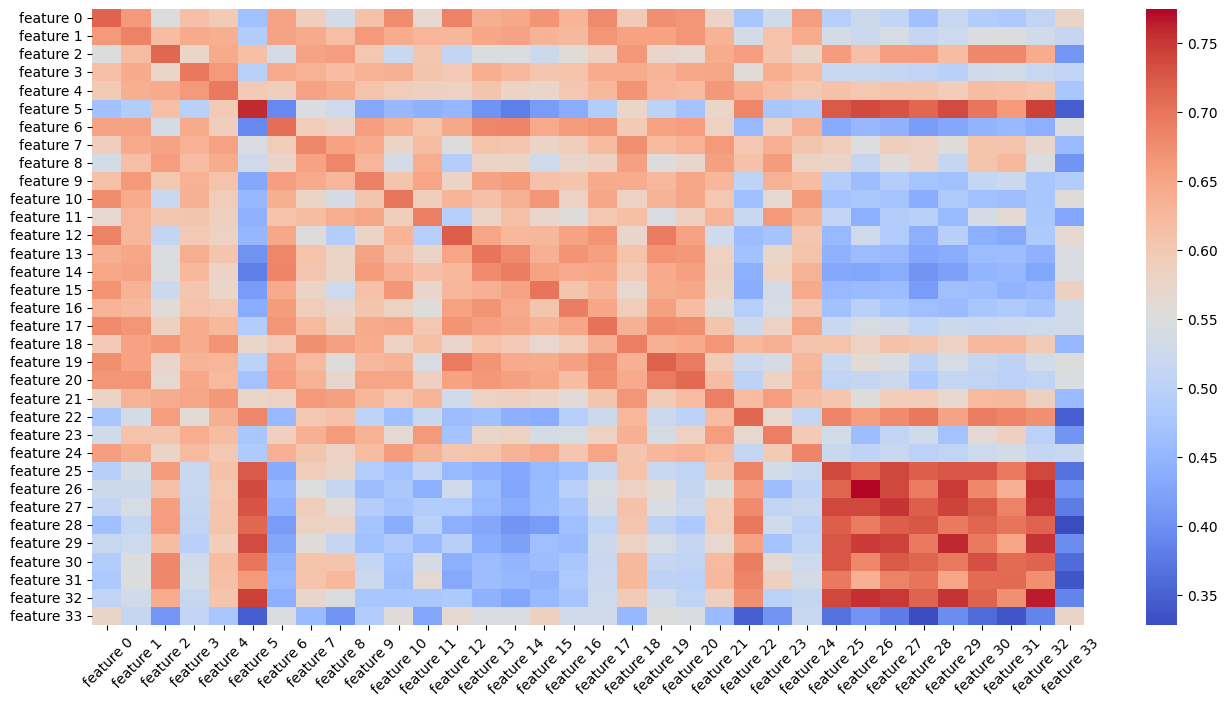

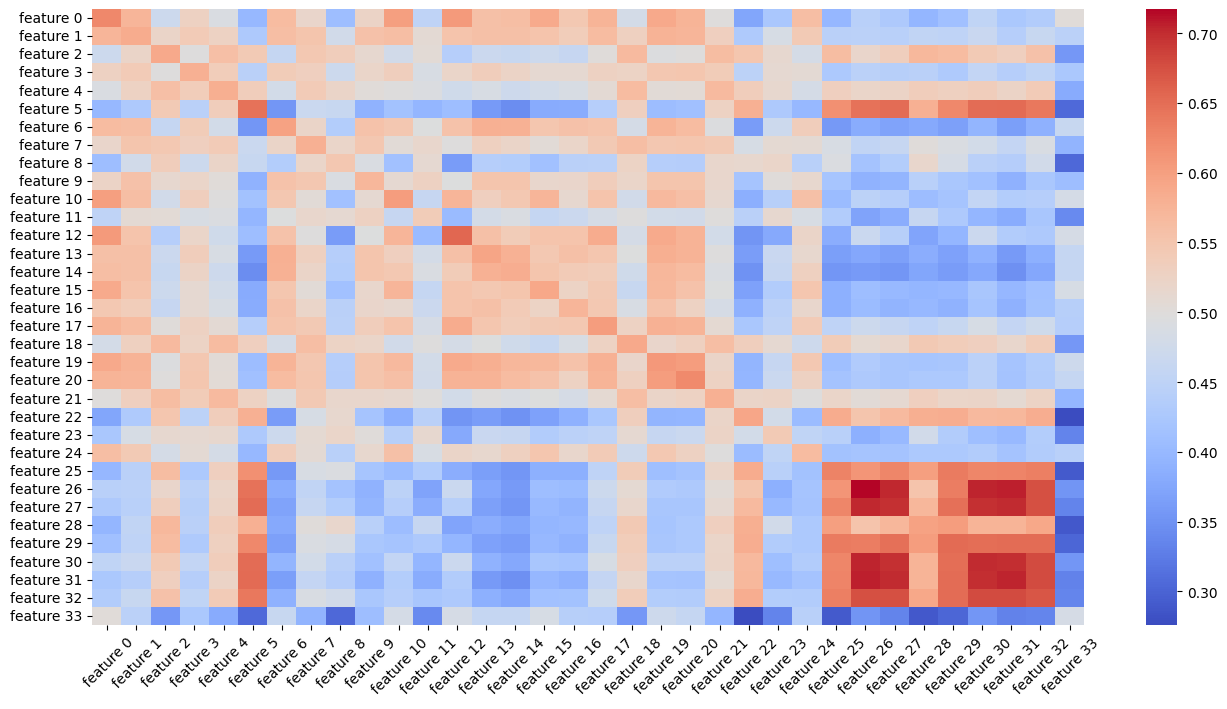

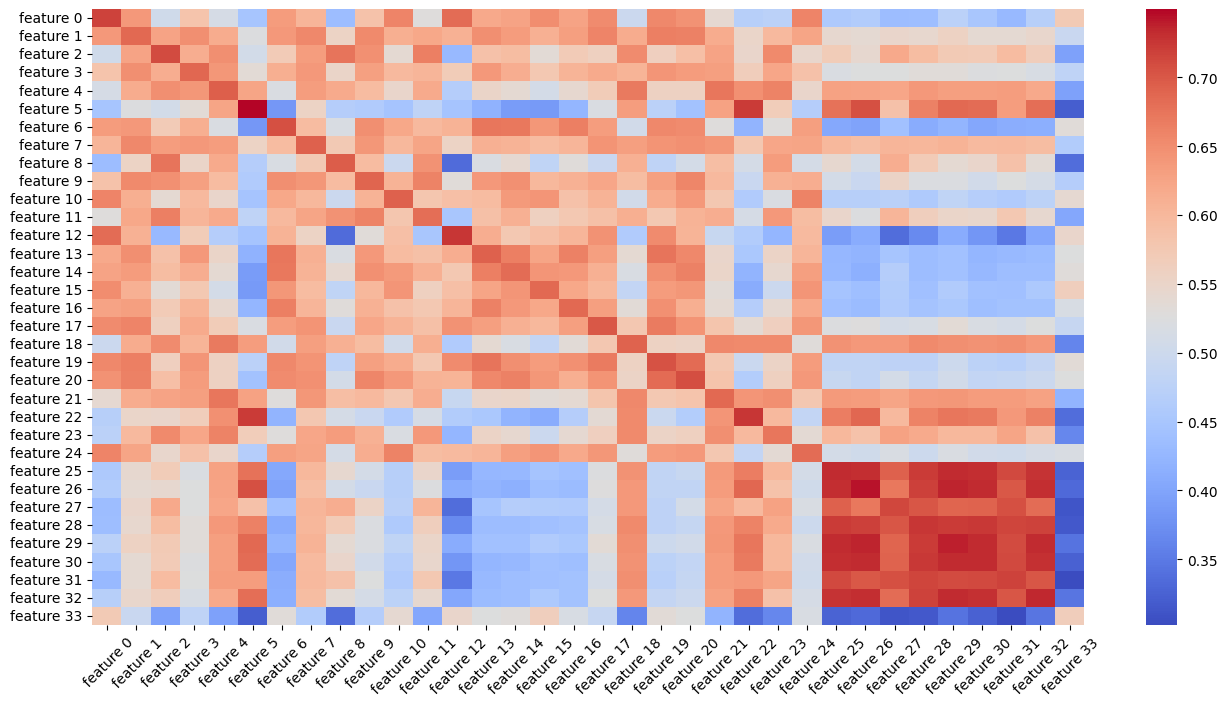

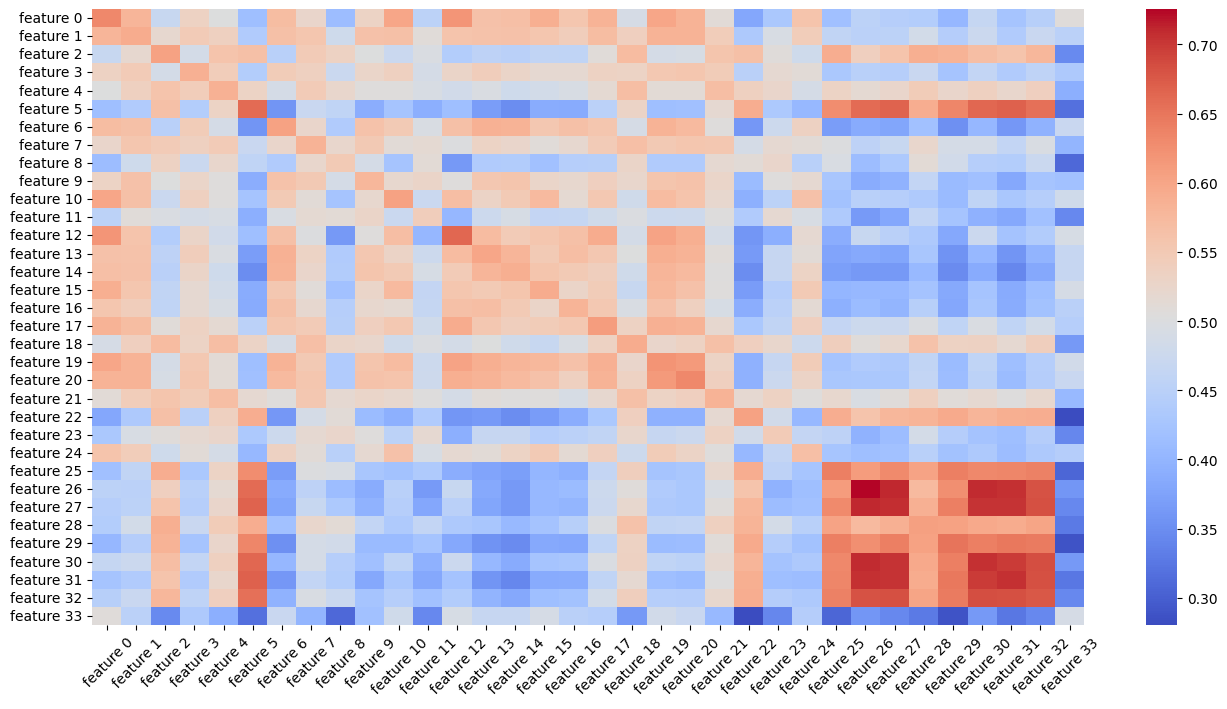

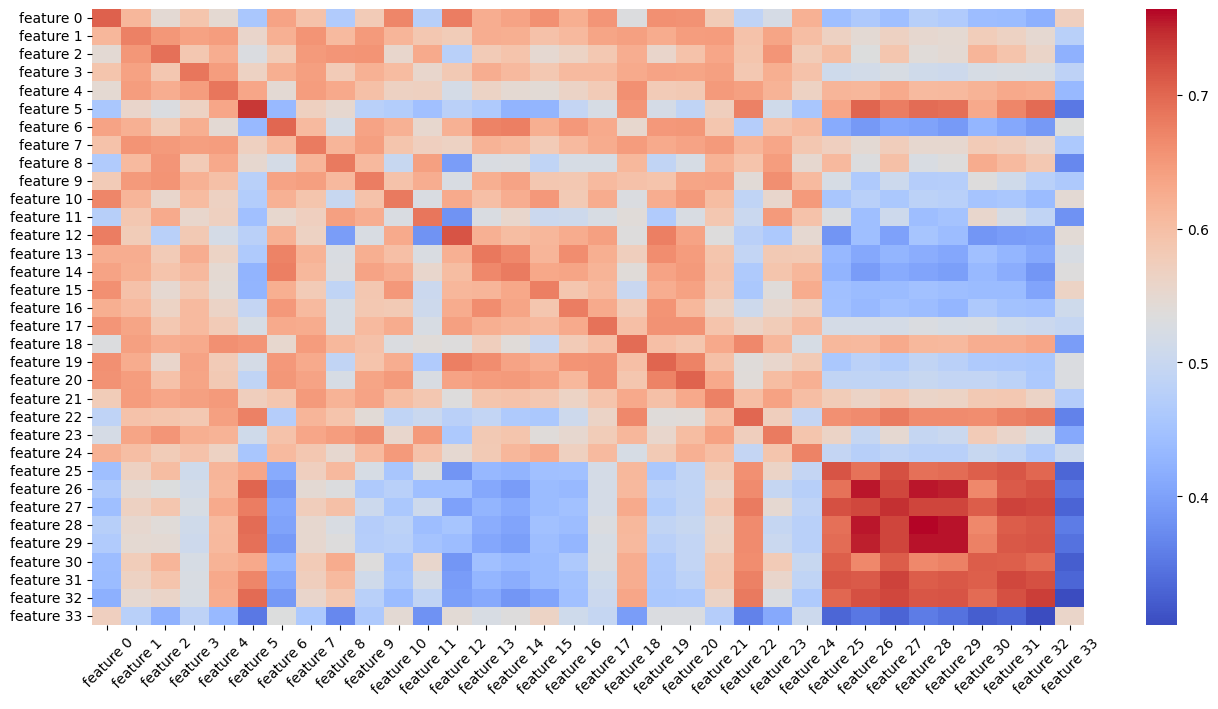

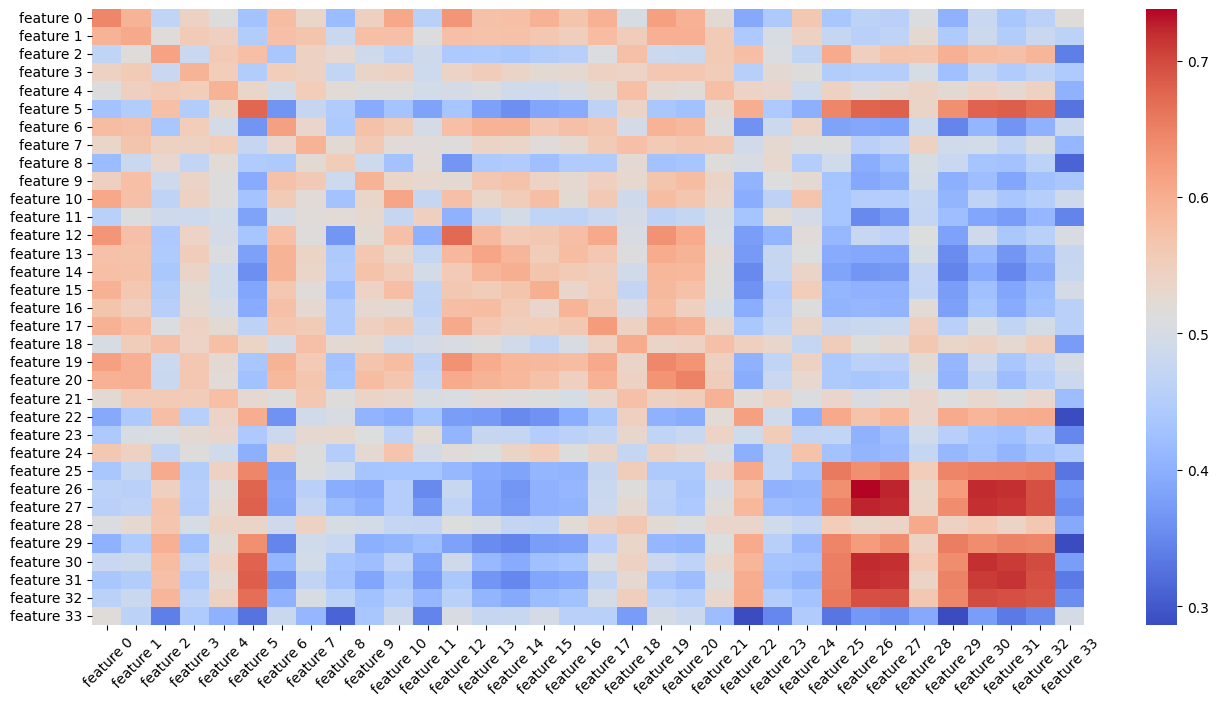

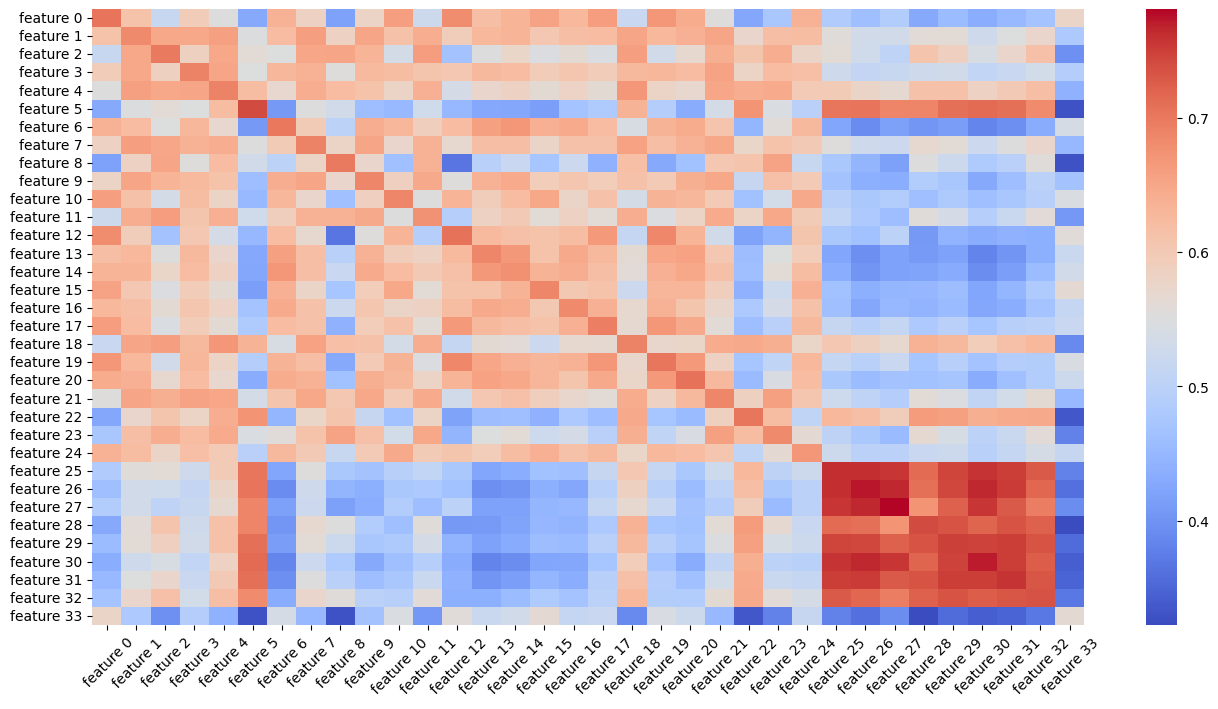

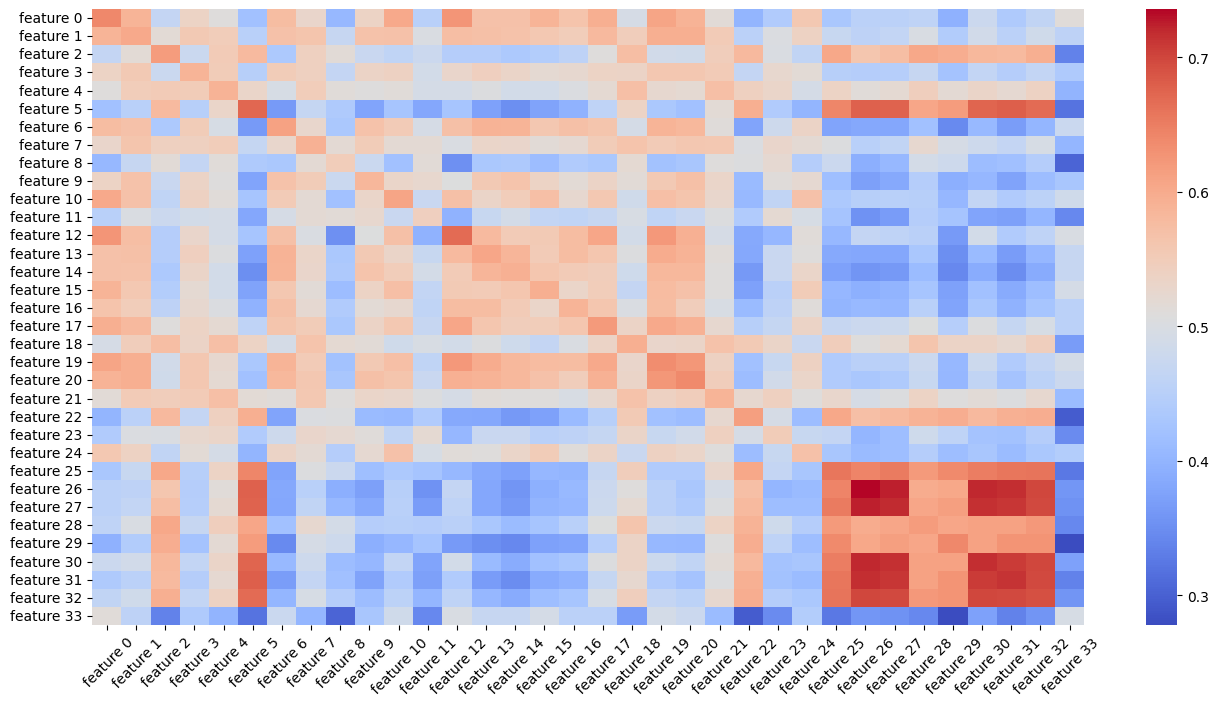

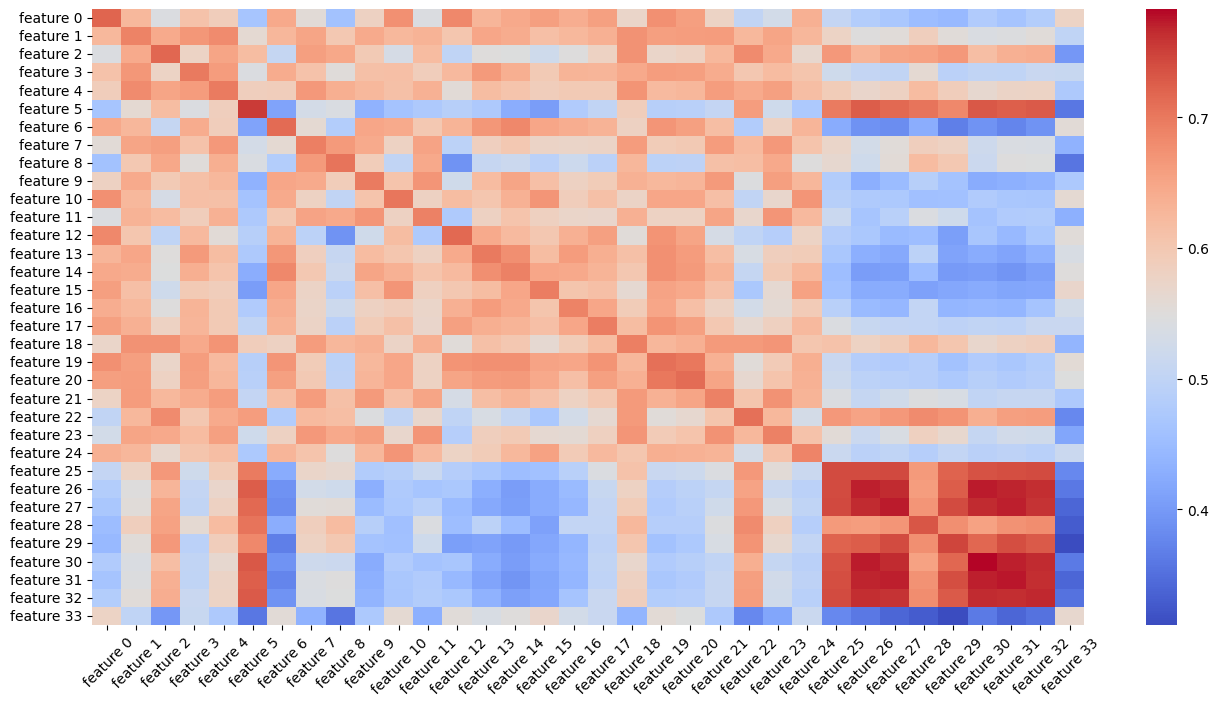

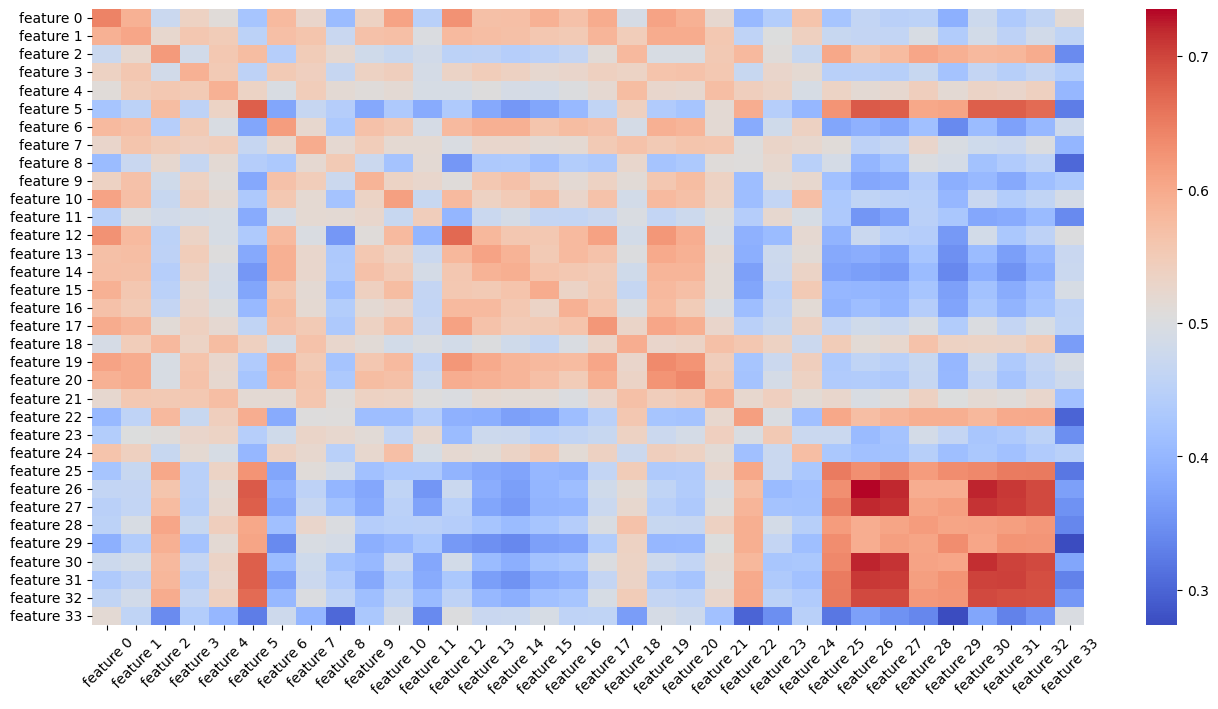

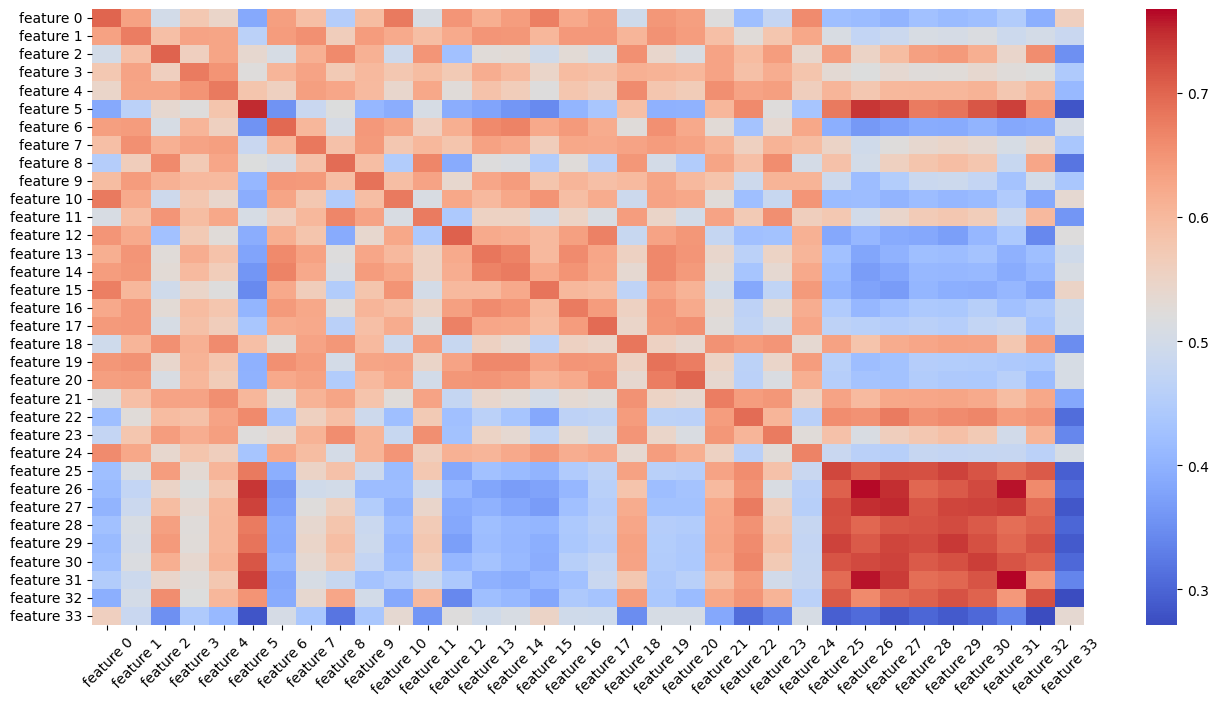

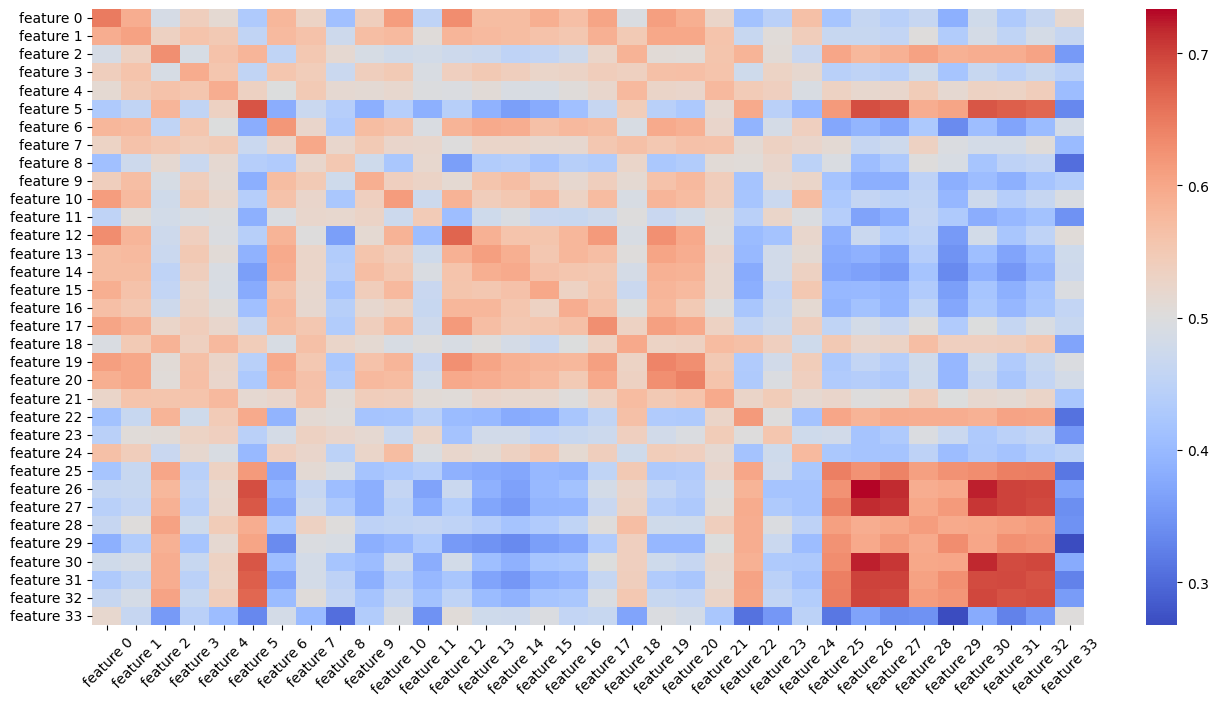

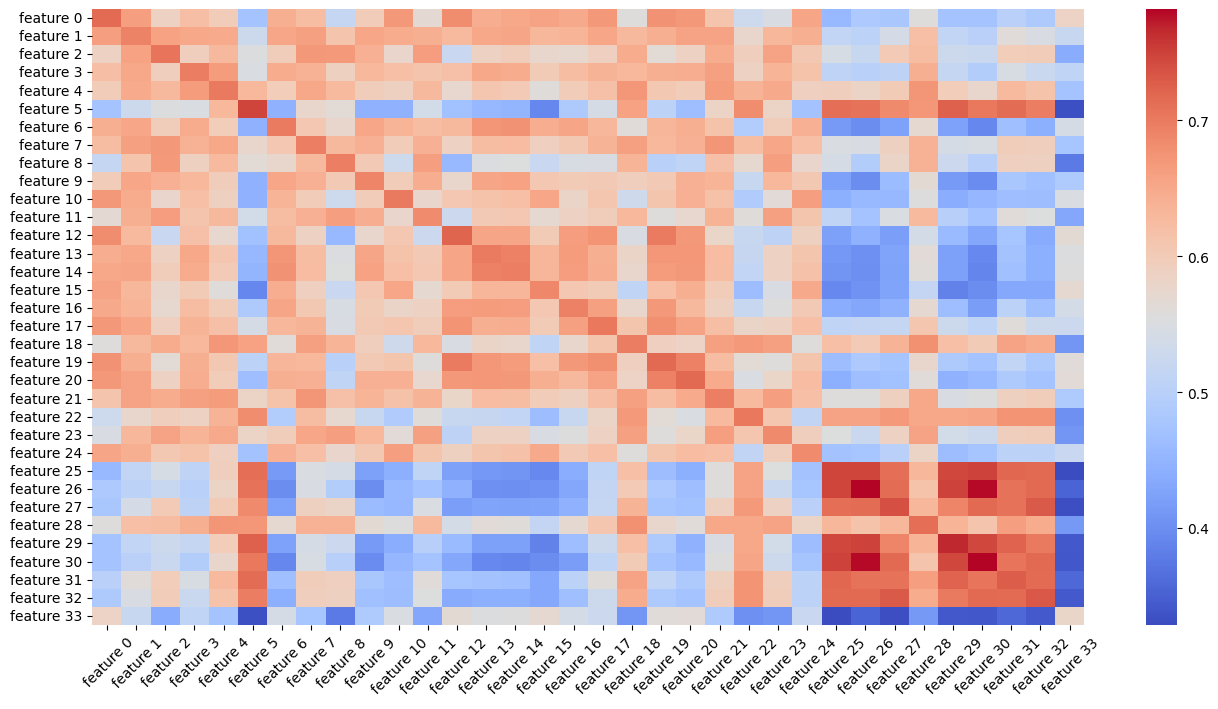

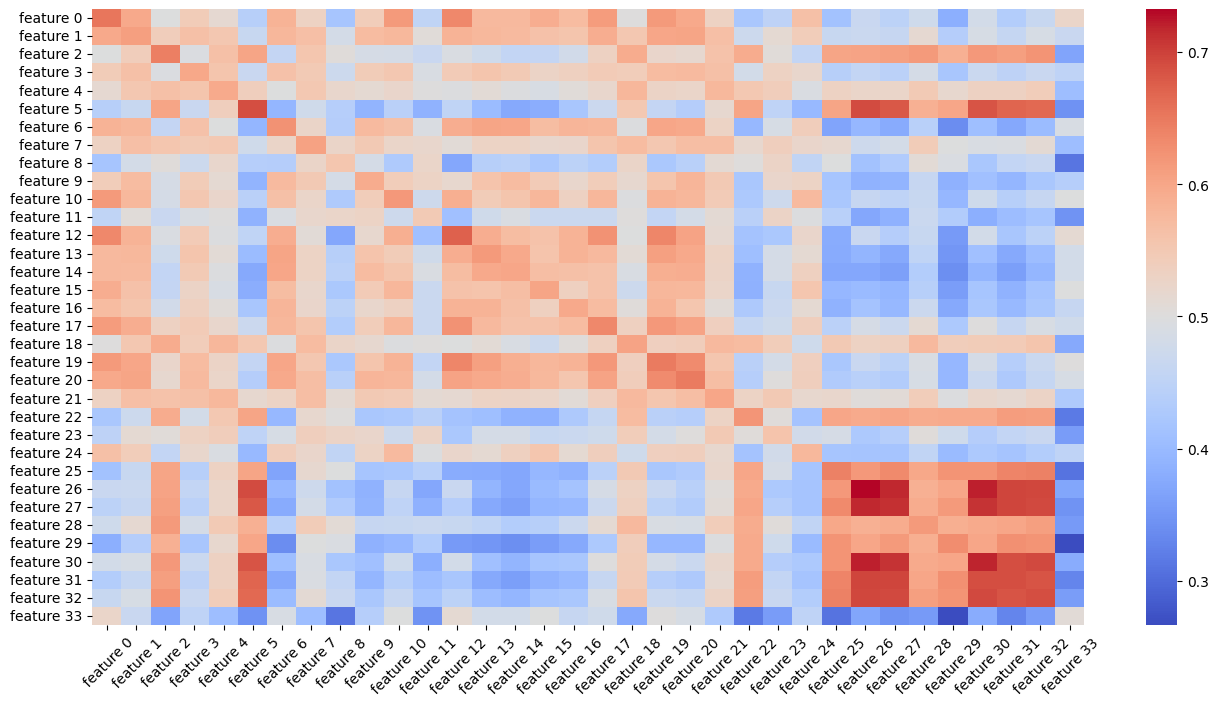

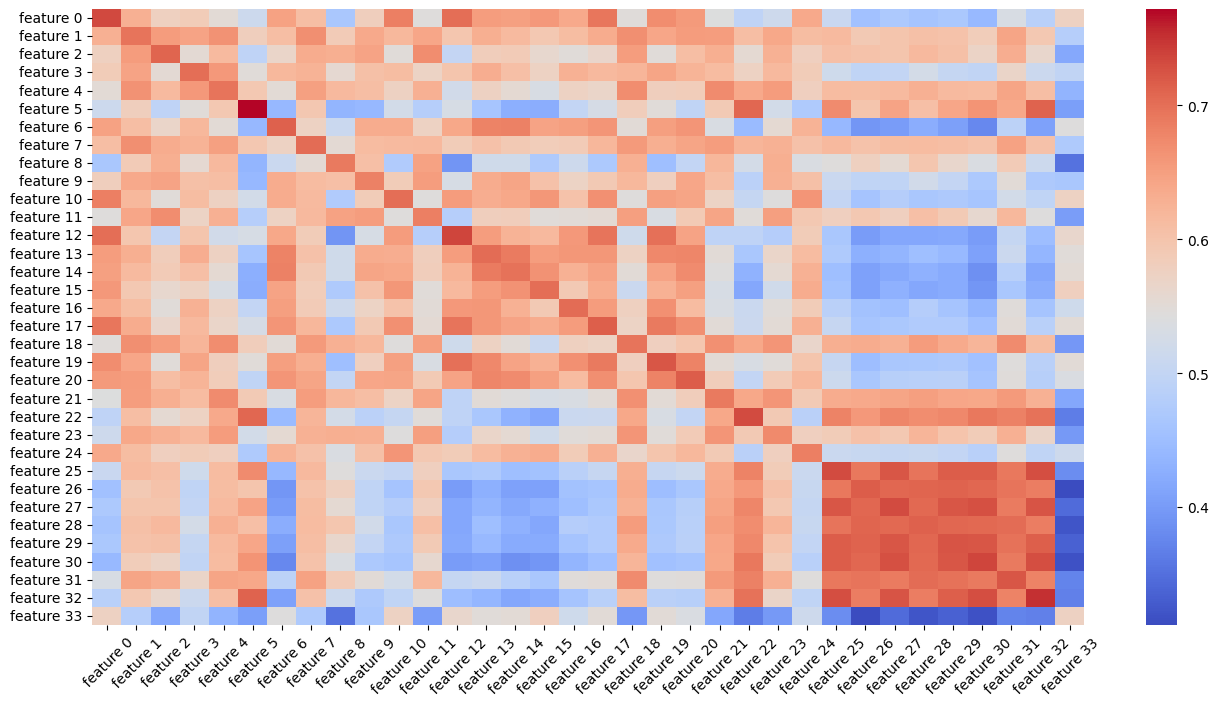

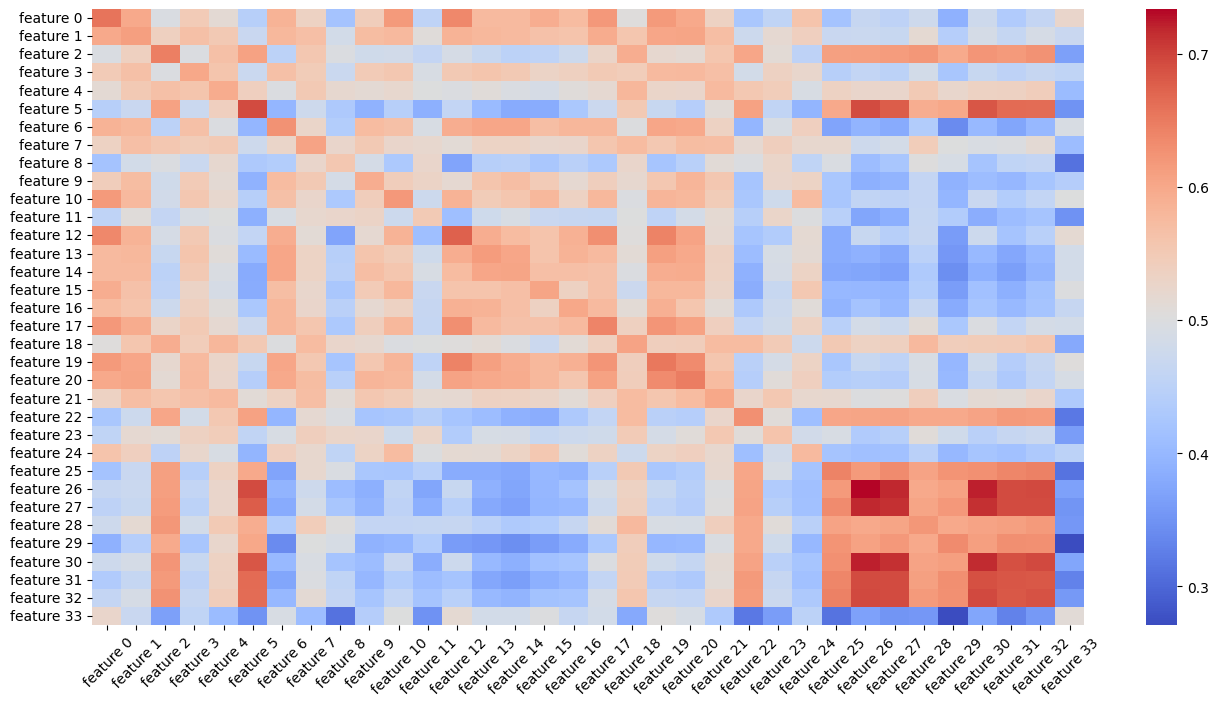

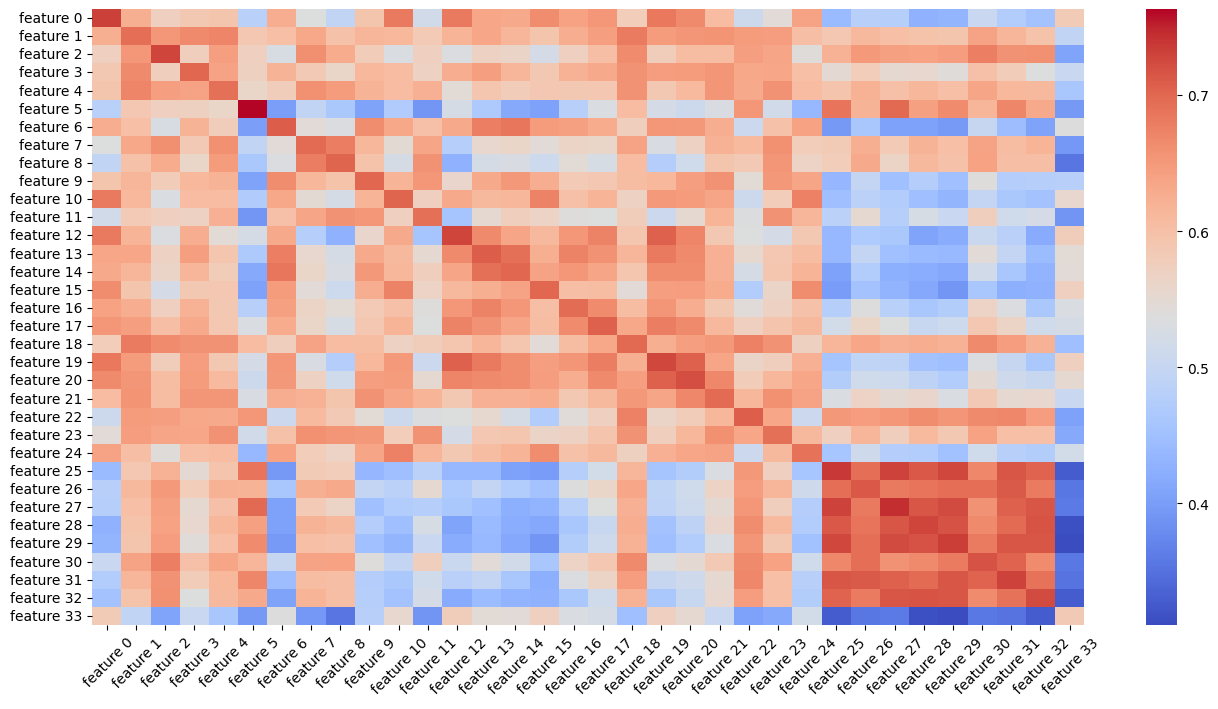

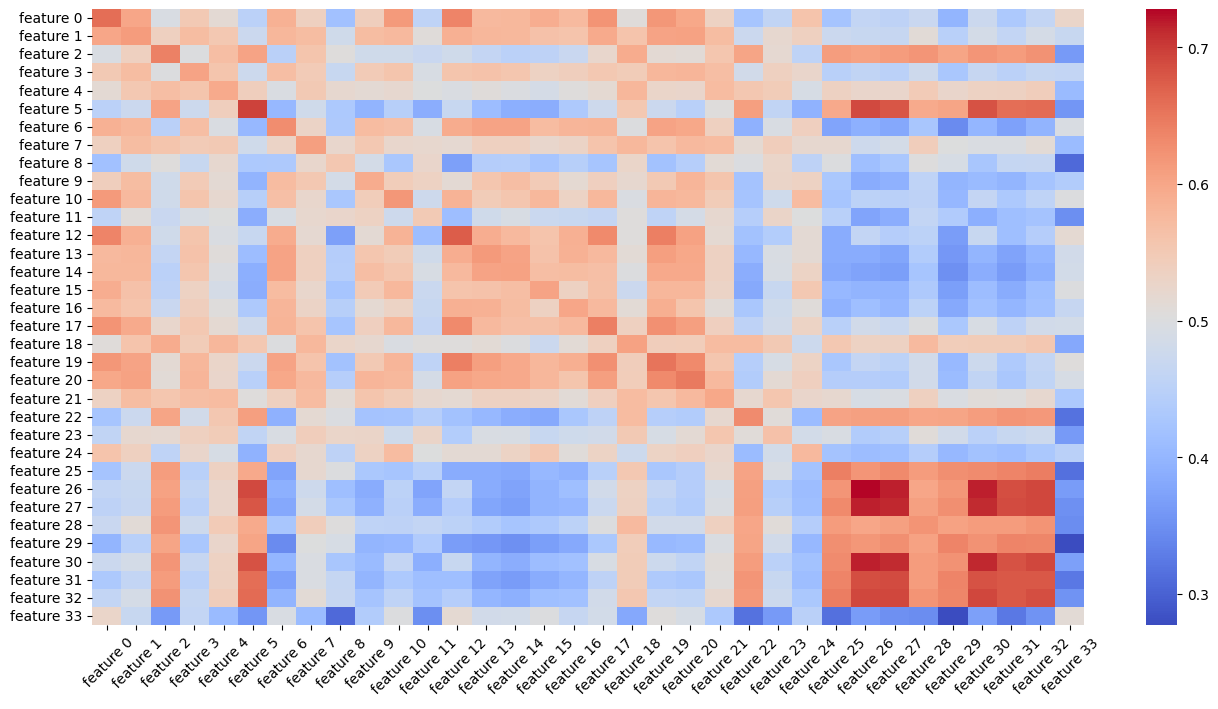

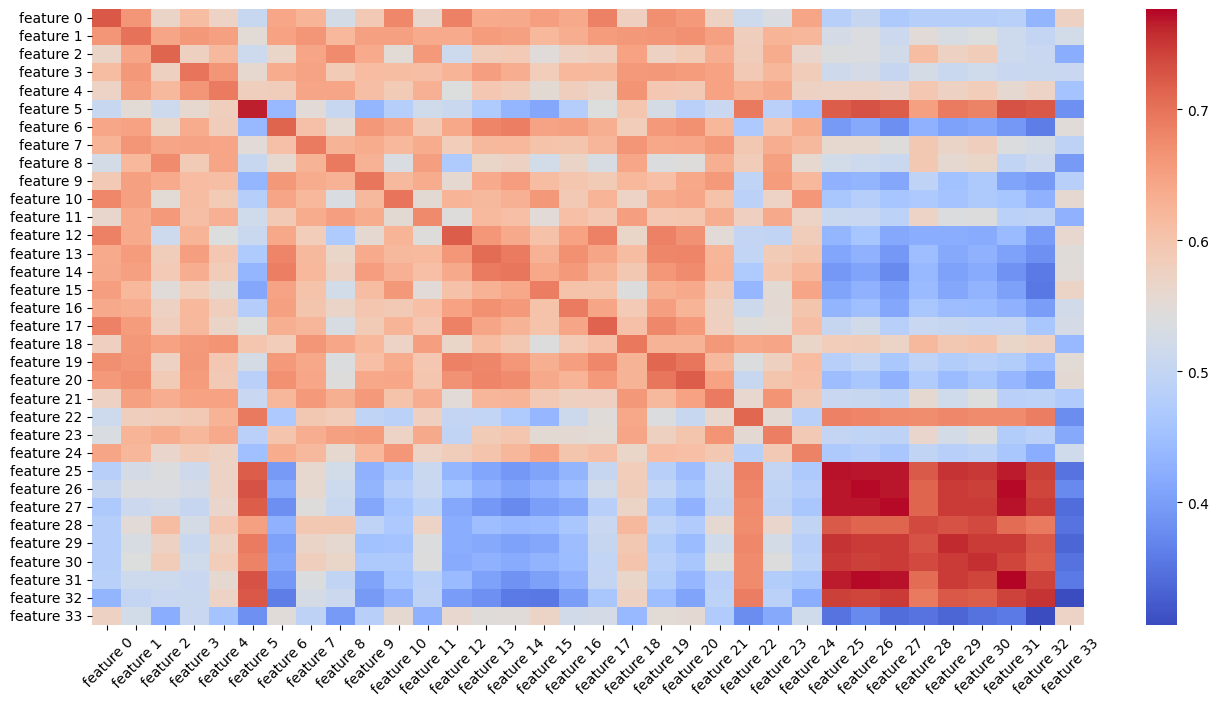

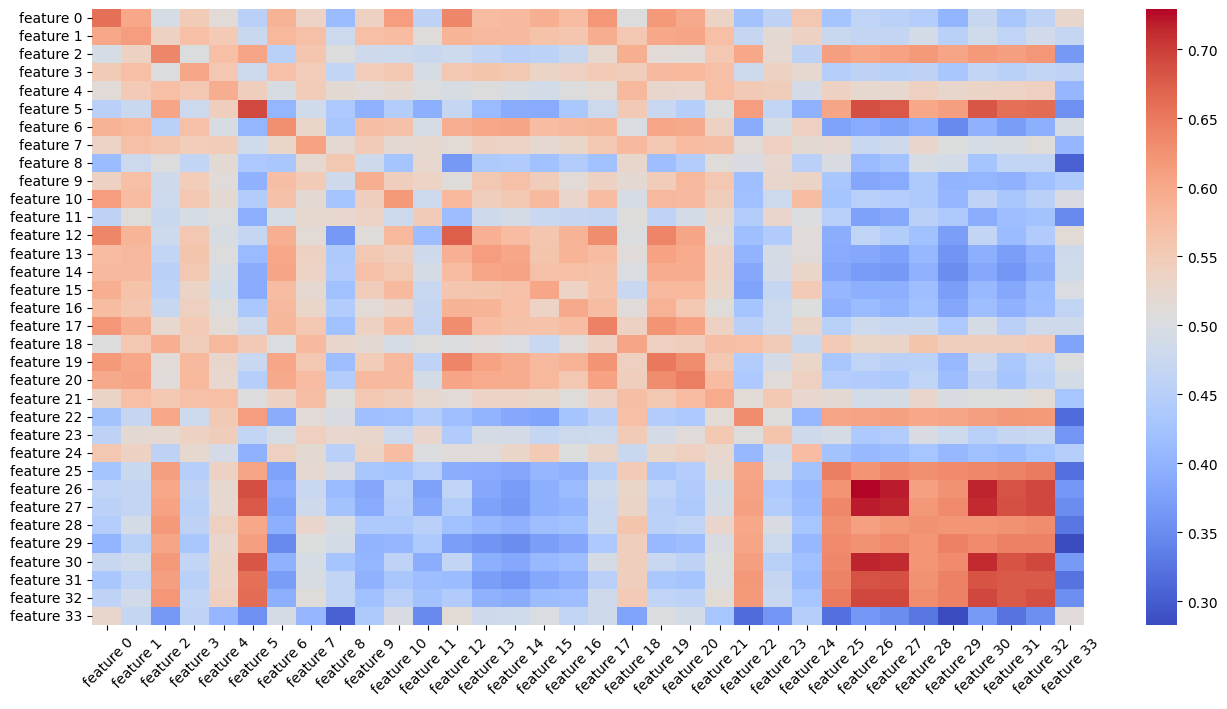

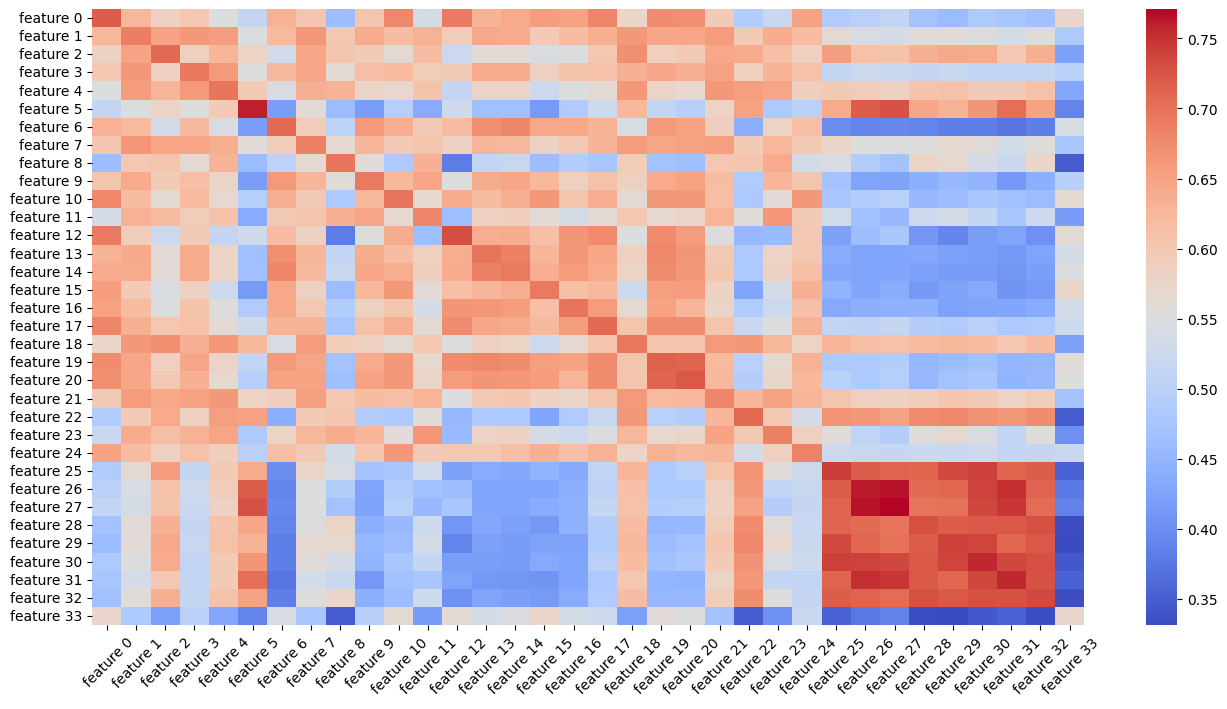

Error in callback <function flush_figures at 0x7f45624e8ee0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [4]:
accuracy_scores = []
for seed in range(1):
    torch.manual_seed(seed)
    train_len = int(len(dataset) * 0.8)
    test_len = len(dataset) - train_len

    train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

    X_train = train_dataset.dataset.x[train_dataset.indices]
    y_train = train_dataset.dataset.y[train_dataset.indices]
    X_test = test_dataset.dataset.x[test_dataset.indices]
    y_test = test_dataset.dataset.y[test_dataset.indices]
    text_train = train_dataset.dataset.embeddings[train_dataset.indices]
    text_test = test_dataset.dataset.embeddings[test_dataset.indices]
        
    for i in range(X_train.shape[1]):
        col = X_train[:, i]
        col[np.isnan(col)] = np.nanmin(col) - 1
    for i in range(X_test.shape[1]):
        col = X_test[:, i]
        col[np.isnan(col)] = np.nanmin(col) - 1

    torch.cuda.empty_cache()

    save_path_to_fine_tuned_model = "./finetuned_mmpfn_airbnb.ckpt"

    fine_tune_mmpfn(
        # path_to_base_model="auto",
        save_path_to_fine_tuned_model=save_path_to_fine_tuned_model,
        # Finetuning HPs
        time_limit=60,
        finetuning_config={"learning_rate": 0.00001, "batch_size": 1, "max_steps": 100},
        validation_metric="log_loss",
        # Input Data
        X_train=pd.DataFrame(X_train),
        image_train=text_train,
        y_train=pd.Series(y_train),
        categorical_features_index=None,
        device="cuda",  # use "cpu" if you don't have a GPU
        task_type="multiclass",
        # Optional
        show_training_curve=False,  # Shows a final report after finetuning.
        logger_level=0,  # Shows all logs, higher values shows less
        freeze_input=True,  # Freeze the input layers (encoder and y_encoder) during finetuning
        mixer_type='MGM+CQAM', # MGM MGM+CQAM
        mgm_heads=16,
        cqam_heads=8,
    )

    # disables preprocessing at inference time to match fine-tuning
    no_preprocessing_inference_config = ModelInterfaceConfig(
        FINGERPRINT_FEATURE=False,
        PREPROCESS_TRANSFORMS=[PreprocessorConfig(name='none')]
    )

    # Evaluate on Test Data
    model_finetuned = MMPFNClassifier(
        model_path=save_path_to_fine_tuned_model,
        inference_config=no_preprocessing_inference_config,
        ignore_pretraining_limits=True,
        mixer_type='MGM+CQAM', # MGM MGM+CQAM
        mgm_heads=16,
        cqam_heads=8,
    )

    clf_finetuned = model_finetuned.fit(X_train, text_train, y_train)
    acc_score = accuracy_score(y_test, clf_finetuned.predict(X_test, text_test))
    print("accuracy_score (Finetuned):", acc_score)
    accuracy_scores.append(acc_score)

In [ ]:
# get mean and std of accuracy scores
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)
print("Std Accuracy:", std_accuracy)